In [ ]:
# Paths
data_path = "/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species"
metadata_path = "/kaggle/input/xeno-canto-indian-10-species-dataset/metadata.csv"
output_csv_path = "/kaggle/working/extracted_features.csv"
temp_wav_dir = "/kaggle/working/temp_wav_files"

In [4]:
pip install python_speech_features


  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=bc92589cbb695bac758bc47397e7eccb3c2c80da8b9004e39fea9c6154c47bcb
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Note: you may need to restart the kernel to use updated packages.


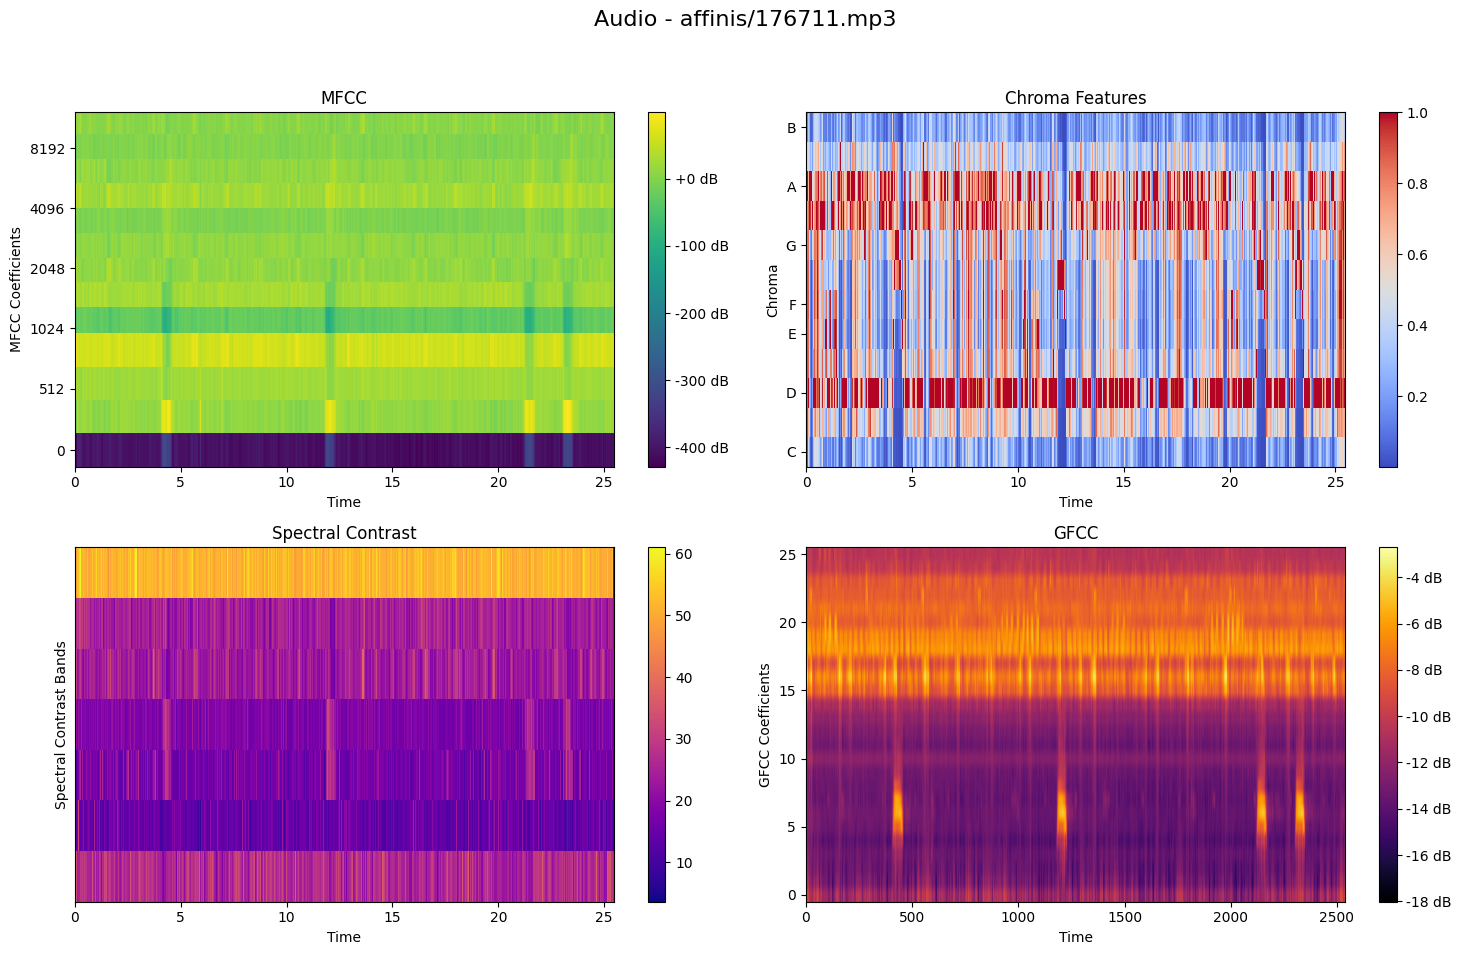

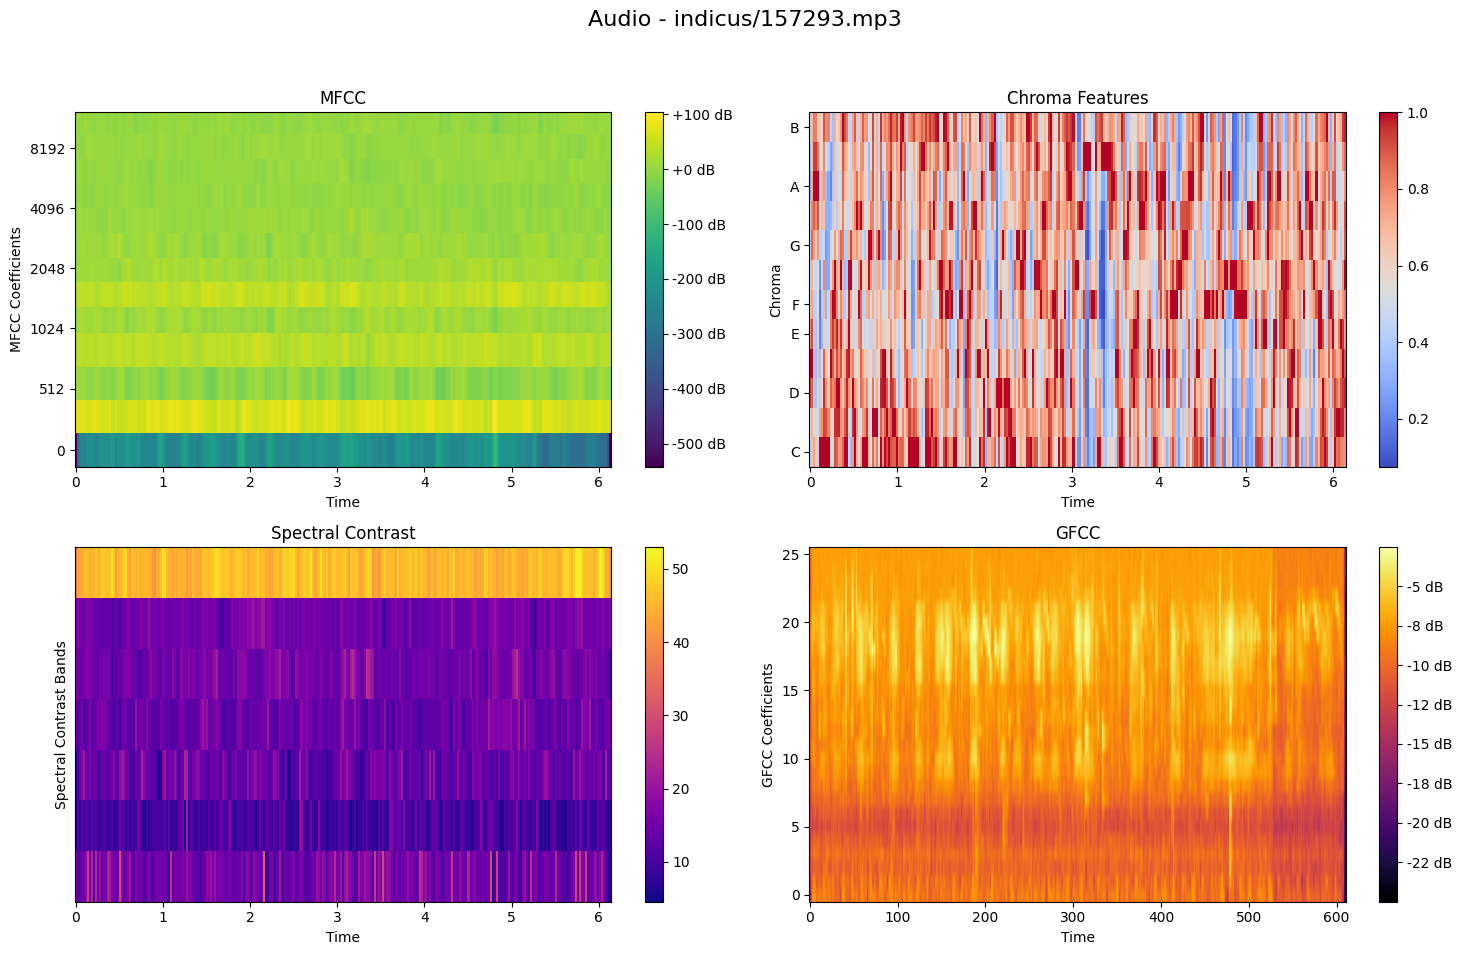

Note: Illegal Audio-MPEG-Header 0x00000000 at offset 452080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


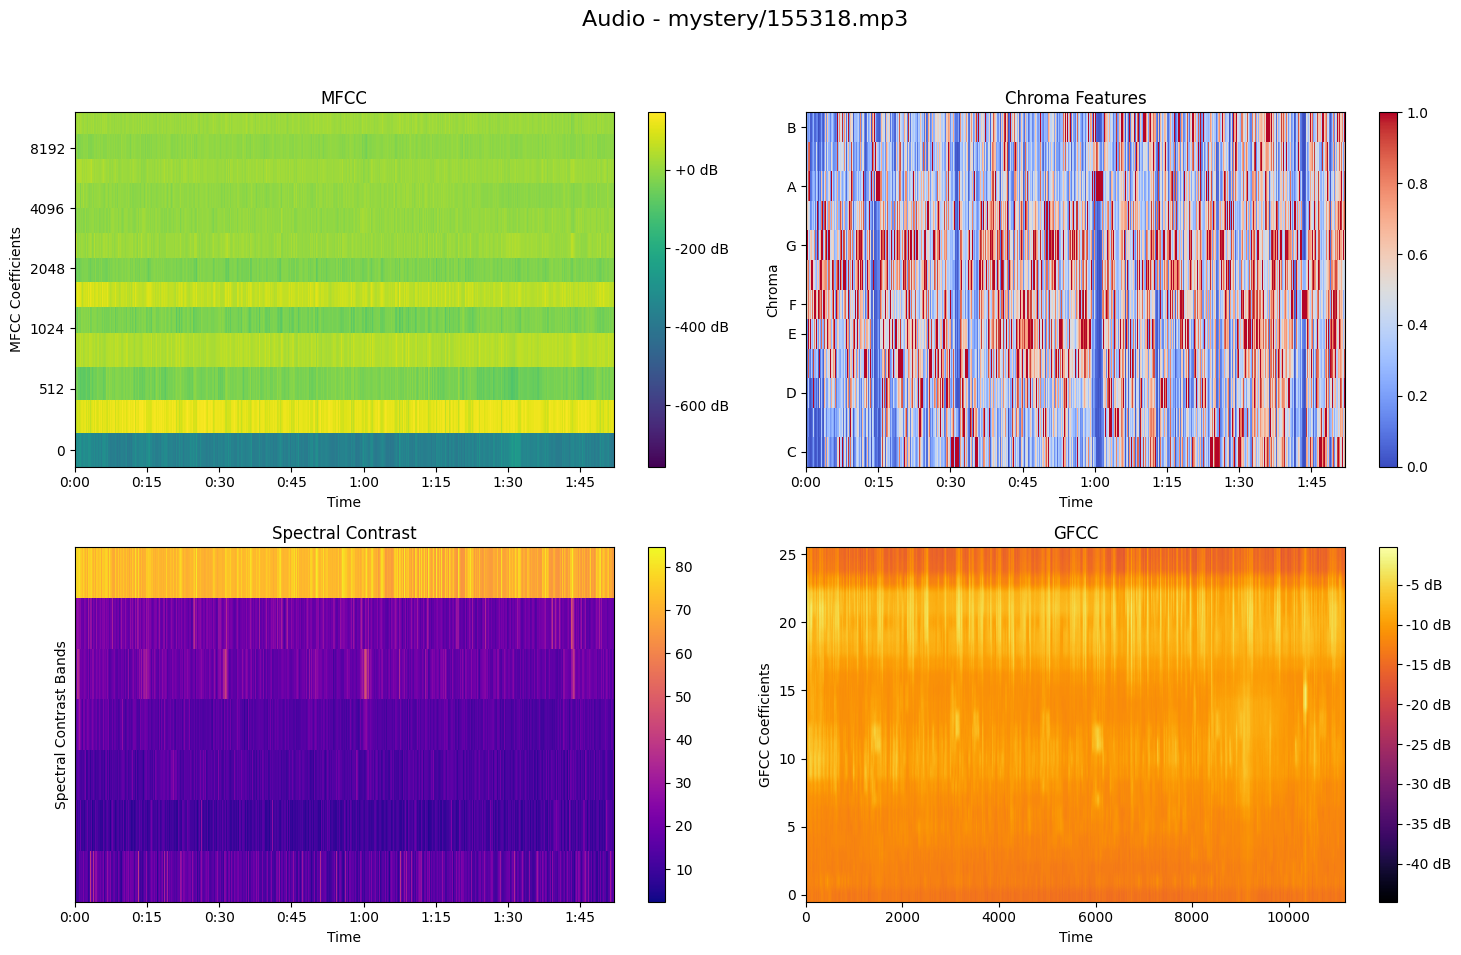

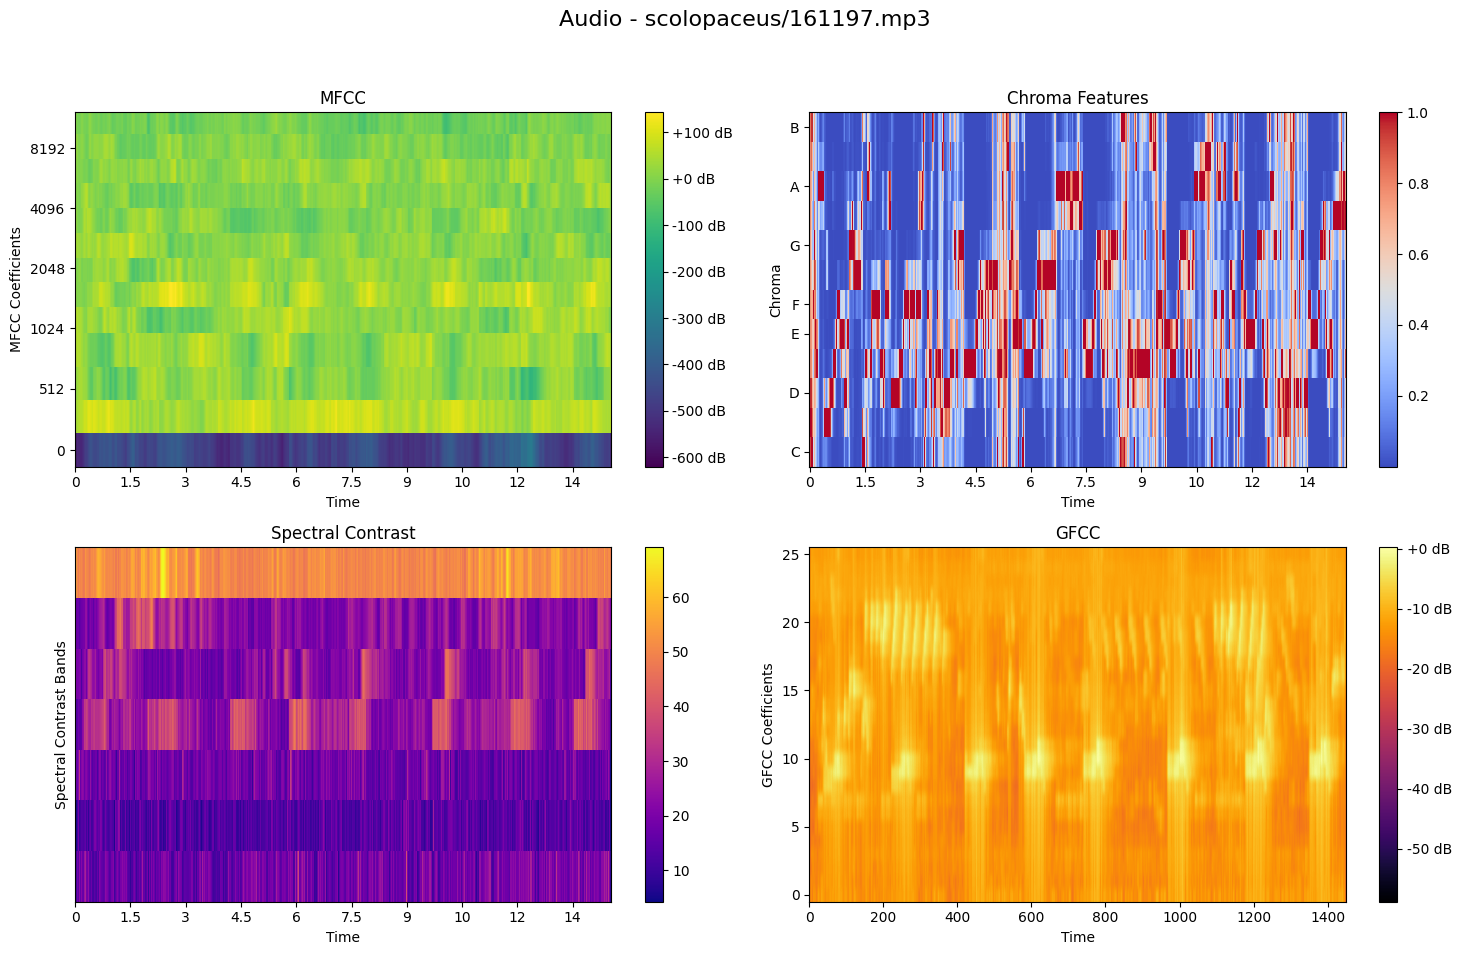

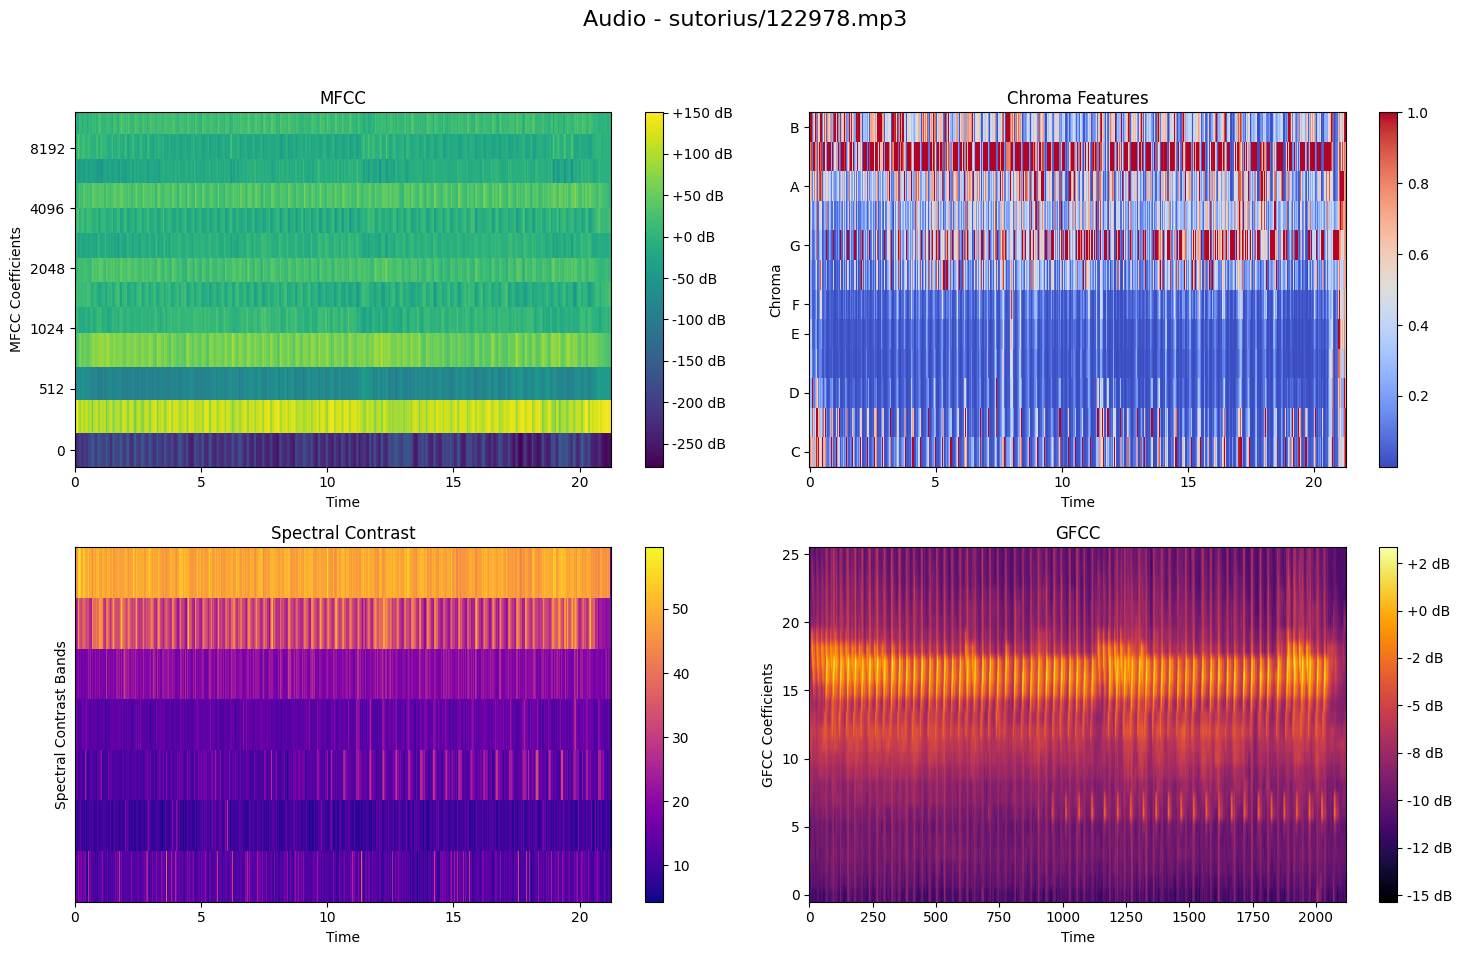

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from python_speech_features import logfbank
import os

# Specify the paths to your 5 audio files
audio_files = [
   '/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/affinis/176711.mp3',
   '/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/indicus/157293.mp3',
   '/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/mystery/155318.mp3',
   '/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/scolopaceus/161197.mp3',
   '/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/sutorius/122978.mp3'
]

# Function to extract GFCC using python_speech_features
def compute_gfcc(y, sr):
    # Compute log-mel filterbank energies
    gfcc_features = logfbank(y, samplerate=sr, nfilt=26, nfft=512)
    return gfcc_features.T  # Transpose for proper visualization

# Function to extract species name and file name from the path
def get_audio_info(audio_file):
    species = os.path.basename(os.path.dirname(audio_file))
    file_name = os.path.splitext(os.path.basename(audio_file))[0]
    return species, file_name

# Function to extract and visualize features with species and file name display in a 2x2 grid
def visualize_features(audio_file, audio_number):
    y, sr = librosa.load(audio_file)
    species, file_name = get_audio_info(audio_file)

    # Create a 2x2 grid for the plots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Audio - {species}/{file_name}.mp3', fontsize=16)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    img1 = librosa.display.specshow(mfcc, sr=sr, x_axis='time', y_axis='mel', ax=axs[0, 0], cmap='viridis')
    axs[0, 0].set_title('MFCC')
    axs[0, 0].set_xlabel('Time')
    axs[0, 0].set_ylabel('MFCC Coefficients')
    fig.colorbar(img1, ax=axs[0, 0], format='%+2.0f dB')

    # Chroma
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    img2 = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=axs[0, 1], cmap='coolwarm')
    axs[0, 1].set_title('Chroma Features')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('Chroma')
    fig.colorbar(img2, ax=axs[0, 1])

    # Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    img3 = librosa.display.specshow(spectral_contrast, sr=sr, x_axis='time', ax=axs[1, 0], cmap='plasma')
    axs[1, 0].set_title('Spectral Contrast')
    axs[1, 0].set_xlabel('Time')
    axs[1, 0].set_ylabel('Spectral Contrast Bands')
    fig.colorbar(img3, ax=axs[1, 0])

    # GFCC
    gfcc = compute_gfcc(y, sr)
    img4 = axs[1, 1].imshow(gfcc, aspect='auto', origin='lower', cmap='inferno')
    axs[1, 1].set_title('GFCC')
    axs[1, 1].set_xlabel('Time')
    axs[1, 1].set_ylabel('GFCC Coefficients')
    fig.colorbar(img4, ax=axs[1, 1], format='%+2.0f dB')

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize features for each audio file with species and file name
for i, audio_file in enumerate(audio_files, start=1):
    visualize_features(audio_file, i)


In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from pydub import AudioSegment
import time

# Paths
data_path = "/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species"
metadata_path = "/kaggle/input/xeno-canto-indian-10-species-dataset/metadata.csv"
output_csv_path = "/kaggle/working/extracted_features.csv"
temp_wav_dir = "/kaggle/working/temp_wav_files"

# Load metadata
metadata = pd.read_csv(metadata_path)

# Ensure WAV directory exists
os.makedirs(temp_wav_dir, exist_ok=True)

# Convert MP3 to WAV
def convert_to_wav(mp3_path, wav_path):
    try:
        audio = AudioSegment.from_file(mp3_path)
        audio.export(wav_path, format="wav")
        return wav_path
    except Exception as e:
        print(f"Failed to convert {mp3_path} to WAV: {e}")
        return None

# Feature extraction function
def extract_features(file_path):
    try:
        start_time = time.time()
        audio, sr = librosa.load(file_path, sr=None, mono=True, res_type='kaiser_fast')
        print(f"Audio loaded in {time.time() - start_time:.2f} seconds")
        
        # Extract features
        mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sr).T, axis=0)
        
        # Combine all features
        features = np.hstack([mfcc, chroma, spectral_contrast])
        return features
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Process all audio files and extract features
extracted_data = []
failed_files = []

folders = os.listdir(data_path)
print(f"Total folders: {len(folders)}")

for species_folder in tqdm(folders, desc="Processing folders"):
    species_folder_path = os.path.join(data_path, species_folder)
    
    if os.path.isdir(species_folder_path):
        files = os.listdir(species_folder_path)
        print(f"Processing {len(files)} files in folder: {species_folder}")
        
        for file in tqdm(files, desc=f"Processing files in {species_folder}", leave=False):
            if file.endswith('.mp3'):
                mp3_path = os.path.join(species_folder_path, file)
                wav_path = os.path.join(temp_wav_dir, f"{os.path.splitext(file)[0]}.wav")
                wav_file = convert_to_wav(mp3_path, wav_path)
                if wav_file:
                    # Extract features
                    features = extract_features(wav_file)
                    if features is not None:
                        # Append metadata and features
                        try:
                            file_id = int(file.split('.')[0])
                            metadata_row = metadata[metadata['id'] == file_id]
                            
                            if not metadata_row.empty:
                                row = {
                                    'id': file_id,
                                    'species': species_folder,
                                    'location': metadata_row['loc'].values[0],
                                    'latitude': metadata_row['lat'].values[0],
                                    'longitude': metadata_row['lng'].values[0],
                                }
                                row.update({f'feature_{i}': features[i] for i in range(len(features))})
                                extracted_data.append(row)
                        except Exception as e:
                            print(f"Error associating metadata for file {file}: {e}")
                    else:
                        failed_files.append(mp3_path)
                else:
                    failed_files.append(mp3_path)

# Save extracted features and failed files
extracted_features_df = pd.DataFrame(extracted_data)
extracted_features_df.to_csv(output_csv_path, index=False)

failed_files_path = "/kaggle/working/failed_files.txt"
with open(failed_files_path, "w") as f:
    f.writelines("\n".join(failed_files))

print(f"Feature extraction complete. Saved to {output_csv_path}.")
print(f"Failed files logged to {failed_files_path}.")


Total folders: 10


Processing folders:   0%|          | 0/10 [00:00<?, ?it/s]

Processing 156 files in folder: indicus



Processing files in indicus:   1%|          | 1/156 [00:00<01:07,  2.28it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:   1%|▏         | 2/156 [00:01<01:37,  1.58it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:   2%|▏         | 3/156 [00:01<01:39,  1.54it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:   3%|▎         | 4/156 [00:02<01:48,  1.40it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:   3%|▎         | 5/156 [00:03<01:39,  1.52it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:   4%|▍         | 7/156 [00:04<01:28,  1.69it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:   5%|▌         | 8/156 [00:04<01:15,  1.95it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in indicus:   6%|▋         | 10/156 [00:05<01:08,  2.14it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:   8%|▊         | 12/156 [00:06<01:02,  2.30it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:   8%|▊         | 13/156 [00:06<00:59,  2.42it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  10%|▉         | 15/156 [00:08<01:08,  2.06it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.04 seconds



Processing files in indicus:  10%|█         | 16/156 [00:08<01:21,  1.71it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  12%|█▏        | 18/156 [00:10<01:17,  1.77it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  12%|█▏        | 19/156 [00:10<01:11,  1.92it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in indicus:  13%|█▎        | 20/156 [00:11<01:18,  1.73it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  13%|█▎        | 21/156 [00:11<01:22,  1.64it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  14%|█▍        | 22/156 [00:12<01:28,  1.52it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  15%|█▌        | 24/156 [00:13<01:11,  1.85it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in indicus:  16%|█▌        | 25/156 [00:14<01:39,  1.31it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  17%|█▋        | 26/156 [00:15<01:29,  1.45it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  18%|█▊        | 28/156 [00:16<01:13,  1.74it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  19%|█▊        | 29/156 [00:16<01:10,  1.81it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  20%|█▉        | 31/156 [00:17<01:02,  1.99it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in indicus:  21%|██        | 32/156 [00:18<01:13,  1.70it/s]

Audio loaded in 0.18 seconds



Processing files in indicus:  22%|██▏       | 34/156 [00:21<01:50,  1.11it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  23%|██▎       | 36/156 [00:22<01:20,  1.49it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  24%|██▎       | 37/156 [00:22<01:08,  1.73it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  25%|██▌       | 39/156 [00:23<01:01,  1.90it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  26%|██▌       | 40/156 [00:25<01:41,  1.15it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  27%|██▋       | 42/156 [00:26<01:18,  1.46it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.09 seconds



Processing files in indicus:  28%|██▊       | 44/156 [00:28<01:28,  1.27it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  29%|██▉       | 46/156 [00:29<01:06,  1.64it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  30%|███       | 47/156 [00:29<01:03,  1.71it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  31%|███       | 48/156 [00:30<01:04,  1.68it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  31%|███▏      | 49/156 [00:31<01:08,  1.56it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  32%|███▏      | 50/156 [00:32<01:30,  1.17it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  33%|███▎      | 51/156 [00:33<01:19,  1.32it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  33%|███▎      | 52/156 [00:35<02:23,  1.38s/it]

Audio loaded in 0.04 seconds



Processing files in indicus:  34%|███▍      | 53/156 [00:36<02:04,  1.20s/it]

Audio loaded in 0.01 seconds



Processing files in indicus:  35%|███▍      | 54/156 [00:37<01:47,  1.05s/it]

Audio loaded in 0.07 seconds



Processing files in indicus:  35%|███▌      | 55/156 [00:38<01:52,  1.12s/it]

Audio loaded in 0.02 seconds



Processing files in indicus:  37%|███▋      | 57/156 [00:39<01:15,  1.31it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.09 seconds



Processing files in indicus:  38%|███▊      | 59/156 [00:41<01:20,  1.20it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  39%|███▉      | 61/156 [00:42<00:58,  1.63it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  40%|███▉      | 62/156 [00:42<00:57,  1.63it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  40%|████      | 63/156 [00:43<00:58,  1.58it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  41%|████      | 64/156 [00:44<00:57,  1.60it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  42%|████▏     | 66/156 [00:45<00:48,  1.87it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.10 seconds



Processing files in indicus:  43%|████▎     | 67/156 [00:46<01:19,  1.11it/s]

Audio loaded in 0.07 seconds



Processing files in indicus:  44%|████▍     | 69/156 [00:48<01:10,  1.24it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in indicus:  45%|████▍     | 70/156 [00:49<01:09,  1.23it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  46%|████▌     | 71/156 [00:50<01:08,  1.23it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  46%|████▌     | 72/156 [00:50<01:08,  1.23it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  47%|████▋     | 74/156 [00:52<00:55,  1.47it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in indicus:  48%|████▊     | 75/156 [00:52<00:56,  1.43it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  49%|████▉     | 77/156 [00:53<00:42,  1.85it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  50%|█████     | 78/156 [00:54<00:38,  2.04it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  51%|█████     | 79/156 [00:54<00:38,  2.02it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  51%|█████▏    | 80/156 [00:56<01:10,  1.08it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  53%|█████▎    | 82/156 [00:57<00:51,  1.45it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  54%|█████▍    | 84/156 [00:58<00:41,  1.74it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in indicus:  54%|█████▍    | 85/156 [00:59<00:45,  1.55it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  55%|█████▌    | 86/156 [00:59<00:43,  1.63it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  56%|█████▌    | 87/156 [01:00<00:42,  1.61it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  56%|█████▋    | 88/156 [01:03<01:37,  1.43s/it]

Audio loaded in 0.01 seconds



Processing files in indicus:  58%|█████▊    | 90/156 [01:05<01:09,  1.06s/it]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  58%|█████▊    | 91/156 [01:06<01:01,  1.06it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  60%|█████▉    | 93/156 [01:07<00:44,  1.43it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in indicus:  60%|██████    | 94/156 [01:08<00:50,  1.23it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  62%|██████▏   | 96/156 [01:09<00:37,  1.58it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in indicus:  62%|██████▏   | 97/156 [01:09<00:35,  1.67it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  63%|██████▎   | 99/156 [01:10<00:29,  1.93it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  64%|██████▍   | 100/156 [01:10<00:26,  2.11it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  65%|██████▍   | 101/156 [01:11<00:24,  2.21it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  65%|██████▌   | 102/156 [01:11<00:27,  1.98it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  66%|██████▌   | 103/156 [01:14<00:58,  1.11s/it]

Audio loaded in 0.01 seconds



Processing files in indicus:  67%|██████▋   | 104/156 [01:15<00:52,  1.00s/it]

Audio loaded in 0.02 seconds



Processing files in indicus:  67%|██████▋   | 105/156 [01:15<00:43,  1.17it/s]

Audio loaded in 0.05 seconds



Processing files in indicus:  69%|██████▊   | 107/156 [01:16<00:34,  1.41it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  69%|██████▉   | 108/156 [01:17<00:32,  1.50it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  71%|███████   | 110/156 [01:18<00:26,  1.72it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  72%|███████▏  | 112/156 [01:20<00:31,  1.42it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.06 seconds



Processing files in indicus:  72%|███████▏  | 113/156 [01:21<00:35,  1.21it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  73%|███████▎  | 114/156 [01:22<00:30,  1.39it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  74%|███████▎  | 115/156 [01:22<00:27,  1.48it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  74%|███████▍  | 116/156 [01:23<00:24,  1.65it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  76%|███████▌  | 118/156 [01:24<00:21,  1.75it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in indicus:  76%|███████▋  | 119/156 [01:25<00:29,  1.26it/s]

Audio loaded in 0.05 seconds



Processing files in indicus:  77%|███████▋  | 120/156 [01:26<00:29,  1.23it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  78%|███████▊  | 122/156 [01:27<00:21,  1.55it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in indicus:  79%|███████▉  | 124/156 [01:28<00:20,  1.58it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  80%|████████  | 125/156 [01:29<00:17,  1.79it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  81%|████████▏ | 127/156 [01:29<00:13,  2.10it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  82%|████████▏ | 128/156 [01:30<00:11,  2.38it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  83%|████████▎ | 129/156 [01:30<00:12,  2.14it/s]

Audio loaded in 0.07 seconds



Processing files in indicus:  83%|████████▎ | 130/156 [01:32<00:18,  1.41it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  84%|████████▍ | 131/156 [01:32<00:16,  1.54it/s]

Audio loaded in 0.04 seconds



Processing files in indicus:  85%|████████▌ | 133/156 [01:33<00:13,  1.68it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  86%|████████▌ | 134/156 [01:34<00:12,  1.83it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in indicus:  87%|████████▋ | 135/156 [01:34<00:12,  1.69it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  87%|████████▋ | 136/156 [01:35<00:11,  1.68it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  88%|████████▊ | 137/156 [01:36<00:12,  1.57it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  89%|████████▉ | 139/156 [01:38<00:12,  1.33it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in indicus:  90%|█████████ | 141/156 [01:39<00:10,  1.38it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  91%|█████████ | 142/156 [01:40<00:08,  1.60it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in indicus:  92%|█████████▏| 144/156 [01:41<00:06,  1.83it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/75121.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Audio loaded in 0.01 seconds



Processing files in indicus:  94%|█████████▎| 146/156 [01:42<00:05,  1.72it/s]

Audio loaded in 0.02 seconds



Processing files in indicus:  94%|█████████▍| 147/156 [01:42<00:04,  1.97it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  95%|█████████▍| 148/156 [01:43<00:03,  2.18it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in indicus:  96%|█████████▌| 150/156 [01:44<00:03,  1.99it/s]

Audio loaded in 0.01 seconds



Processing files in indicus:  97%|█████████▋| 151/156 [01:44<00:02,  2.06it/s]

Audio loaded in 0.00 seconds



Processing files in indicus:  97%|█████████▋| 152/156 [01:45<00:01,  2.22it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in indicus:  98%|█████████▊| 153/156 [01:46<00:02,  1.21it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  99%|█████████▊| 154/156 [01:47<00:01,  1.25it/s]

Audio loaded in 0.03 seconds



Processing files in indicus:  99%|█████████▉| 155/156 [01:48<00:00,  1.30it/s]

Audio loaded in 0.02 seconds



Processing folders:  10%|█         | 1/10 [01:48<16:18, 108.77s/it]           

Processing 128 files in folder: affinis



Processing files in affinis:   0%|          | 0/128 [00:00<?, ?it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:   2%|▏         | 2/128 [00:01<01:07,  1.87it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:   2%|▏         | 3/128 [00:01<00:57,  2.18it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in affinis:   3%|▎         | 4/128 [00:02<01:12,  1.70it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:   4%|▍         | 5/128 [00:03<01:18,  1.56it/s]

Audio loaded in 0.05 seconds



Processing files in affinis:   5%|▌         | 7/128 [00:04<01:07,  1.80it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/303515.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Audio loaded in 0.02 seconds



Processing files in affinis:   6%|▋         | 8/128 [00:04<01:08,  1.76it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:   7%|▋         | 9/128 [00:05<01:06,  1.79it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:   8%|▊         | 10/128 [00:05<01:06,  1.77it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:   9%|▊         | 11/128 [00:06<01:14,  1.56it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  10%|█         | 13/128 [00:09<01:54,  1.01it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in affinis:  11%|█         | 14/128 [00:10<01:52,  1.02it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  12%|█▏        | 15/128 [00:11<01:38,  1.14it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  12%|█▎        | 16/128 [00:12<01:33,  1.20it/s]

Audio loaded in 0.07 seconds



Processing files in affinis:  13%|█▎        | 17/128 [00:16<03:35,  1.95s/it]

Audio loaded in 0.02 seconds



Processing files in affinis:  14%|█▍        | 18/128 [00:17<02:45,  1.50s/it]

Audio loaded in 0.05 seconds



Processing files in affinis:  15%|█▍        | 19/128 [00:17<02:24,  1.33s/it]

Audio loaded in 0.02 seconds



Processing files in affinis:  16%|█▌        | 20/128 [00:19<02:37,  1.46s/it]

Audio loaded in 0.04 seconds



Processing files in affinis:  16%|█▋        | 21/128 [00:20<02:15,  1.26s/it]

Audio loaded in 0.04 seconds



Processing files in affinis:  17%|█▋        | 22/128 [00:21<01:58,  1.12s/it]

Audio loaded in 0.02 seconds



Processing files in affinis:  18%|█▊        | 23/128 [00:21<01:41,  1.03it/s]

Audio loaded in 0.06 seconds



Processing files in affinis:  19%|█▉        | 24/128 [00:23<01:46,  1.02s/it]

Audio loaded in 0.00 seconds



Processing files in affinis:  20%|██        | 26/128 [00:23<01:10,  1.44it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  21%|██        | 27/128 [00:24<01:00,  1.67it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in affinis:  22%|██▏       | 28/128 [00:25<01:08,  1.46it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  23%|██▎       | 29/128 [00:25<01:04,  1.54it/s]

Audio loaded in 0.06 seconds



Processing files in affinis:  24%|██▍       | 31/128 [00:27<00:59,  1.62it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  25%|██▌       | 32/128 [00:27<00:52,  1.83it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in affinis:  26%|██▌       | 33/128 [00:28<00:54,  1.74it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  27%|██▋       | 35/128 [00:29<00:48,  1.91it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in affinis:  29%|██▉       | 37/128 [00:30<00:44,  2.02it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in affinis:  30%|██▉       | 38/128 [00:30<00:51,  1.73it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  30%|███       | 39/128 [00:31<00:50,  1.77it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  31%|███▏      | 40/128 [00:31<00:51,  1.70it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:  32%|███▏      | 41/128 [00:32<00:56,  1.55it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  33%|███▎      | 42/128 [00:33<00:53,  1.62it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  34%|███▎      | 43/128 [00:33<00:48,  1.74it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  34%|███▍      | 44/128 [00:34<00:46,  1.81it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  35%|███▌      | 45/128 [00:34<00:43,  1.91it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  36%|███▌      | 46/128 [00:35<00:46,  1.75it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  37%|███▋      | 47/128 [00:36<01:02,  1.29it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  38%|███▊      | 49/128 [00:37<00:46,  1.69it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in affinis:  39%|███▉      | 50/128 [00:38<00:51,  1.51it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  40%|███▉      | 51/128 [00:38<00:46,  1.67it/s]

Audio loaded in 0.08 seconds



Processing files in affinis:  41%|████▏     | 53/128 [00:40<00:49,  1.52it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in affinis:  42%|████▏     | 54/128 [00:41<00:48,  1.53it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  44%|████▍     | 56/128 [00:41<00:38,  1.86it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in affinis:  45%|████▍     | 57/128 [00:42<00:41,  1.72it/s]

Audio loaded in 0.06 seconds



Processing files in affinis:  45%|████▌     | 58/128 [00:43<00:52,  1.33it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  46%|████▌     | 59/128 [00:44<00:46,  1.49it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  47%|████▋     | 60/128 [00:45<00:49,  1.38it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:  48%|████▊     | 62/128 [00:46<00:40,  1.63it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in affinis:  49%|████▉     | 63/128 [00:46<00:41,  1.58it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  50%|█████     | 64/128 [00:47<00:48,  1.32it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  51%|█████     | 65/128 [00:48<00:43,  1.46it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  52%|█████▏    | 67/128 [00:49<00:33,  1.80it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in affinis:  53%|█████▎    | 68/128 [00:50<00:39,  1.50it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  54%|█████▍    | 69/128 [00:50<00:39,  1.50it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  55%|█████▌    | 71/128 [00:52<00:37,  1.54it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in affinis:  57%|█████▋    | 73/128 [00:53<00:33,  1.65it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  58%|█████▊    | 74/128 [00:54<00:29,  1.81it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in affinis:  59%|█████▊    | 75/128 [00:55<00:38,  1.37it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  59%|█████▉    | 76/128 [00:55<00:37,  1.40it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  61%|██████    | 78/128 [00:57<00:32,  1.56it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in affinis:  62%|██████▏   | 79/128 [00:57<00:30,  1.61it/s]

Audio loaded in 0.05 seconds



Processing files in affinis:  62%|██████▎   | 80/128 [00:58<00:35,  1.34it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  63%|██████▎   | 81/128 [00:59<00:34,  1.36it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  64%|██████▍   | 82/128 [01:00<00:32,  1.41it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:  65%|██████▍   | 83/128 [01:00<00:32,  1.39it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  66%|██████▌   | 84/128 [01:01<00:31,  1.40it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  66%|██████▋   | 85/128 [01:01<00:27,  1.56it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  67%|██████▋   | 86/128 [01:02<00:25,  1.63it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  68%|██████▊   | 87/128 [01:04<00:37,  1.10it/s]

Audio loaded in 0.05 seconds



Processing files in affinis:  69%|██████▉   | 88/128 [01:05<00:36,  1.09it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:  70%|██████▉   | 89/128 [01:05<00:34,  1.14it/s]

Audio loaded in 0.06 seconds



Processing files in affinis:  70%|███████   | 90/128 [01:06<00:35,  1.06it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  71%|███████   | 91/128 [01:07<00:30,  1.22it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:  72%|███████▏  | 92/128 [01:08<00:29,  1.20it/s]

Audio loaded in 0.22 seconds



Processing files in affinis:  73%|███████▎  | 93/128 [01:11<00:53,  1.52s/it]

Audio loaded in 0.00 seconds



Processing files in affinis:  74%|███████▍  | 95/128 [01:12<00:30,  1.07it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in affinis:  76%|███████▌  | 97/128 [01:13<00:22,  1.36it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.05 seconds



Processing files in affinis:  77%|███████▋  | 99/128 [01:14<00:19,  1.48it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  78%|███████▊  | 100/128 [01:15<00:16,  1.67it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in affinis:  79%|███████▉  | 101/128 [01:16<00:18,  1.45it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  80%|███████▉  | 102/128 [01:16<00:17,  1.51it/s]

Audio loaded in 0.09 seconds



Processing files in affinis:  80%|████████  | 103/128 [01:17<00:21,  1.15it/s]

Audio loaded in 0.06 seconds



Processing files in affinis:  81%|████████▏ | 104/128 [01:19<00:22,  1.08it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  82%|████████▏ | 105/128 [01:19<00:19,  1.19it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  84%|████████▎ | 107/128 [01:20<00:13,  1.53it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  84%|████████▍ | 108/128 [01:21<00:11,  1.67it/s]

Audio loaded in 0.00 seconds


Audio loaded in 0.15 seconds



Processing files in affinis:  85%|████████▌ | 109/128 [01:23<00:19,  1.03s/it]

Audio loaded in 0.05 seconds



Processing files in affinis:  86%|████████▌ | 110/128 [01:24<00:18,  1.00s/it]

Audio loaded in 0.01 seconds



Processing files in affinis:  87%|████████▋ | 111/128 [01:25<00:16,  1.01it/s]

Audio loaded in 0.04 seconds



Processing files in affinis:  88%|████████▊ | 112/128 [01:25<00:14,  1.09it/s]

Audio loaded in 0.07 seconds



Processing files in affinis:  88%|████████▊ | 113/128 [01:27<00:15,  1.02s/it]

Audio loaded in 0.03 seconds



Processing files in affinis:  89%|████████▉ | 114/128 [01:27<00:12,  1.11it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  90%|████████▉ | 115/128 [01:28<00:09,  1.31it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  91%|█████████ | 116/128 [01:28<00:08,  1.45it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  92%|█████████▏| 118/128 [01:29<00:06,  1.66it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  93%|█████████▎| 119/128 [01:30<00:04,  1.89it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in affinis:  94%|█████████▍| 120/128 [01:31<00:06,  1.20it/s]

Audio loaded in 0.01 seconds



Processing files in affinis:  95%|█████████▍| 121/128 [01:33<00:06,  1.03it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  95%|█████████▌| 122/128 [01:34<00:06,  1.13s/it]

Audio loaded in 0.03 seconds



Processing files in affinis:  96%|█████████▌| 123/128 [01:35<00:04,  1.02it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  97%|█████████▋| 124/128 [01:35<00:03,  1.16it/s]

Audio loaded in 0.02 seconds



Processing files in affinis:  98%|█████████▊| 125/128 [01:36<00:02,  1.35it/s]

Audio loaded in 0.00 seconds



Processing files in affinis:  98%|█████████▊| 126/128 [01:36<00:01,  1.49it/s]

Audio loaded in 0.03 seconds



Processing files in affinis:  99%|█████████▉| 127/128 [01:37<00:00,  1.48it/s]

Audio loaded in 0.09 seconds



Processing folders:  20%|██        | 2/10 [03:27<13:43, 102.96s/it]           

Processing 116 files in folder: sutorius



Processing files in sutorius:   0%|          | 0/116 [00:00<?, ?it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:   2%|▏         | 2/116 [00:01<01:03,  1.81it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:   3%|▎         | 3/116 [00:01<00:49,  2.29it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:   3%|▎         | 4/116 [00:01<00:47,  2.34it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in sutorius:   5%|▌         | 6/116 [00:02<00:50,  2.16it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in sutorius:   6%|▌         | 7/116 [00:03<01:01,  1.76it/s]

Audio loaded in 0.05 seconds



Processing files in sutorius:   7%|▋         | 8/116 [00:04<01:14,  1.46it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:   8%|▊         | 9/116 [00:05<01:29,  1.19it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:   9%|▉         | 11/116 [00:06<01:08,  1.54it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  10%|█         | 12/116 [00:07<00:57,  1.82it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  11%|█         | 13/116 [00:07<00:54,  1.89it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  12%|█▏        | 14/116 [00:08<00:55,  1.85it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  13%|█▎        | 15/116 [00:08<00:54,  1.86it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  14%|█▍        | 16/116 [00:09<01:03,  1.58it/s]

Audio loaded in 0.06 seconds



Processing files in sutorius:  15%|█▍        | 17/116 [00:10<01:15,  1.31it/s]

Audio loaded in 0.06 seconds



Processing files in sutorius:  16%|█▌        | 18/116 [00:11<01:24,  1.16it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  17%|█▋        | 20/116 [00:12<01:06,  1.45it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in sutorius:  18%|█▊        | 21/116 [00:13<01:04,  1.47it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  19%|█▉        | 22/116 [00:13<00:59,  1.58it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  20%|█▉        | 23/116 [00:14<01:00,  1.53it/s]

Audio loaded in 0.08 seconds



Processing files in sutorius:  21%|██        | 24/116 [00:16<01:22,  1.12it/s]

Audio loaded in 0.06 seconds



Processing files in sutorius:  22%|██▏       | 25/116 [00:17<01:27,  1.05it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  22%|██▏       | 26/116 [00:17<01:15,  1.20it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  23%|██▎       | 27/116 [00:18<01:13,  1.21it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  24%|██▍       | 28/116 [00:19<01:08,  1.29it/s]

Audio loaded in 0.10 seconds



Processing files in sutorius:  25%|██▌       | 29/116 [00:20<01:29,  1.02s/it]

Audio loaded in 0.02 seconds



Processing files in sutorius:  26%|██▌       | 30/116 [00:21<01:13,  1.17it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  27%|██▋       | 31/116 [00:22<01:08,  1.25it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  28%|██▊       | 32/116 [00:22<01:04,  1.29it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  28%|██▊       | 33/116 [00:23<01:13,  1.14it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  30%|███       | 35/116 [00:25<00:58,  1.39it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in sutorius:  31%|███       | 36/116 [00:25<00:56,  1.43it/s]

Audio loaded in 0.05 seconds



Processing files in sutorius:  33%|███▎      | 38/116 [00:26<00:48,  1.61it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in sutorius:  34%|███▎      | 39/116 [00:27<00:48,  1.60it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  35%|███▌      | 41/116 [00:28<00:39,  1.91it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  36%|███▌      | 42/116 [00:29<00:42,  1.75it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  38%|███▊      | 44/116 [00:30<00:38,  1.88it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  39%|███▉      | 45/116 [00:30<00:33,  2.15it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  41%|████      | 47/116 [00:31<00:33,  2.06it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  41%|████▏     | 48/116 [00:31<00:30,  2.22it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  43%|████▎     | 50/116 [00:32<00:30,  2.16it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  45%|████▍     | 52/116 [00:33<00:29,  2.14it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  46%|████▌     | 53/116 [00:34<00:26,  2.35it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  47%|████▋     | 54/116 [00:34<00:25,  2.44it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  47%|████▋     | 55/116 [00:34<00:24,  2.45it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  48%|████▊     | 56/116 [00:35<00:25,  2.34it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.01 seconds



Processing files in sutorius:  49%|████▉     | 57/116 [00:36<00:31,  1.89it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  50%|█████     | 58/116 [00:36<00:34,  1.69it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  52%|█████▏    | 60/116 [00:37<00:28,  1.99it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in sutorius:  53%|█████▎    | 61/116 [00:38<00:30,  1.83it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  53%|█████▎    | 62/116 [00:39<00:39,  1.35it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  54%|█████▍    | 63/116 [00:40<00:37,  1.40it/s]

Audio loaded in 0.06 seconds



Processing files in sutorius:  55%|█████▌    | 64/116 [00:41<00:42,  1.22it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  56%|█████▌    | 65/116 [00:41<00:37,  1.38it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  58%|█████▊    | 67/116 [00:43<00:31,  1.57it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  59%|█████▉    | 69/116 [00:44<00:26,  1.80it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in sutorius:  60%|██████    | 70/116 [00:44<00:28,  1.62it/s]

Audio loaded in 0.05 seconds



Processing files in sutorius:  61%|██████    | 71/116 [00:45<00:31,  1.43it/s]

Audio loaded in 0.06 seconds



Processing files in sutorius:  63%|██████▎   | 73/116 [00:47<00:29,  1.47it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in sutorius:  64%|██████▍   | 74/116 [00:48<00:37,  1.13it/s]

Audio loaded in 0.06 seconds



Processing files in sutorius:  65%|██████▍   | 75/116 [00:49<00:39,  1.04it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  66%|██████▌   | 76/116 [00:50<00:36,  1.10it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  66%|██████▋   | 77/116 [00:51<00:32,  1.19it/s]

Audio loaded in 0.07 seconds



Processing files in sutorius:  67%|██████▋   | 78/116 [00:52<00:35,  1.06it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  68%|██████▊   | 79/116 [00:52<00:30,  1.22it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  70%|██████▉   | 81/116 [00:53<00:23,  1.47it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  71%|███████   | 82/116 [00:54<00:20,  1.67it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in sutorius:  72%|███████▏  | 83/116 [00:54<00:19,  1.67it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  72%|███████▏  | 84/116 [00:55<00:21,  1.50it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  73%|███████▎  | 85/116 [00:56<00:21,  1.45it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  74%|███████▍  | 86/116 [00:57<00:19,  1.50it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  75%|███████▌  | 87/116 [00:57<00:20,  1.41it/s]

Audio loaded in 0.00 seconds



Processing files in sutorius:  76%|███████▌  | 88/116 [00:58<00:18,  1.49it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  77%|███████▋  | 89/116 [00:59<00:19,  1.41it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  78%|███████▊  | 91/116 [01:00<00:15,  1.65it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  79%|███████▉  | 92/116 [01:00<00:12,  1.93it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.10 seconds



Processing files in sutorius:  81%|████████  | 94/116 [01:02<00:16,  1.34it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.00 seconds



Processing files in sutorius:  82%|████████▏ | 95/116 [01:03<00:14,  1.45it/s]

Audio loaded in 0.03 seconds



Processing files in sutorius:  83%|████████▎ | 96/116 [01:04<00:13,  1.46it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  84%|████████▎ | 97/116 [01:04<00:13,  1.42it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  84%|████████▍ | 98/116 [01:05<00:12,  1.47it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  85%|████████▌ | 99/116 [01:05<00:10,  1.59it/s]

Audio loaded in 0.09 seconds



Processing files in sutorius:  86%|████████▌ | 100/116 [01:07<00:14,  1.10it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  87%|████████▋ | 101/116 [01:08<00:13,  1.15it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  88%|████████▊ | 102/116 [01:09<00:11,  1.22it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  89%|████████▉ | 103/116 [01:09<00:09,  1.39it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  90%|████████▉ | 104/116 [01:10<00:08,  1.48it/s]

Audio loaded in 0.04 seconds



Processing files in sutorius:  91%|█████████ | 105/116 [01:10<00:07,  1.41it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  91%|█████████▏| 106/116 [01:11<00:06,  1.53it/s]

Audio loaded in 0.05 seconds



Processing files in sutorius:  93%|█████████▎| 108/116 [01:12<00:05,  1.54it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  94%|█████████▍| 109/116 [01:13<00:04,  1.67it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.04 seconds



Processing files in sutorius:  96%|█████████▌| 111/116 [01:14<00:02,  1.70it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in sutorius:  97%|█████████▋| 112/116 [01:15<00:02,  1.52it/s]

Audio loaded in 0.02 seconds



Processing files in sutorius:  97%|█████████▋| 113/116 [01:15<00:01,  1.61it/s]

Audio loaded in 0.01 seconds



Processing files in sutorius:  99%|█████████▉| 115/116 [01:17<00:00,  1.66it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing folders:  30%|███       | 3/10 [04:45<10:39, 91.40s/it]             

Processing 342 files in folder: mystery



Processing files in mystery:   0%|          | 0/342 [00:00<?, ?it/s]

Audio loaded in 0.05 seconds



Processing files in mystery:   1%|          | 2/342 [00:01<03:37,  1.56it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:   1%|          | 3/342 [00:02<03:40,  1.54it/s]

Audio loaded in 0.10 seconds



Processing files in mystery:   1%|          | 4/342 [00:03<05:45,  1.02s/it]

Audio loaded in 0.05 seconds



Processing files in mystery:   2%|▏         | 6/342 [00:04<04:24,  1.27it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:   2%|▏         | 7/342 [00:05<03:40,  1.52it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:   2%|▏         | 8/342 [00:05<03:18,  1.68it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:   3%|▎         | 9/342 [00:06<03:04,  1.80it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:   3%|▎         | 10/342 [00:06<03:05,  1.79it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:   3%|▎         | 11/342 [00:07<03:20,  1.65it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:   4%|▎         | 12/342 [00:08<03:24,  1.61it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:   4%|▍         | 14/342 [00:09<03:01,  1.81it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:   4%|▍         | 15/342 [00:10<03:29,  1.56it/s]

Audio loaded in 0.17 seconds



Processing files in mystery:   5%|▍         | 17/342 [00:12<04:55,  1.10it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:   6%|▌         | 19/342 [00:13<03:51,  1.39it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:   6%|▌         | 20/342 [00:14<04:00,  1.34it/s]

Audio loaded in 0.12 seconds



Processing files in mystery:   6%|▌         | 21/342 [00:16<05:45,  1.08s/it]

Audio loaded in 0.13 seconds



Processing files in mystery:   6%|▋         | 22/342 [00:18<07:17,  1.37s/it]

Audio loaded in 0.03 seconds



Processing files in mystery:   7%|▋         | 23/342 [00:19<06:10,  1.16s/it]

Audio loaded in 0.02 seconds



Processing files in mystery:   7%|▋         | 25/342 [00:20<04:19,  1.22it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:   8%|▊         | 26/342 [00:20<03:26,  1.53it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:   8%|▊         | 27/342 [00:20<03:05,  1.70it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:   8%|▊         | 28/342 [00:21<02:37,  2.00it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:   8%|▊         | 29/342 [00:21<02:29,  2.09it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:   9%|▉         | 31/342 [00:22<02:39,  1.95it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:   9%|▉         | 32/342 [00:23<02:46,  1.86it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  10%|▉         | 34/342 [00:24<02:22,  2.15it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  10%|█         | 35/342 [00:24<02:07,  2.41it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  11%|█         | 36/342 [00:25<02:07,  2.41it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  11%|█         | 38/342 [00:26<02:40,  1.90it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  12%|█▏        | 40/342 [00:27<02:43,  1.85it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  12%|█▏        | 41/342 [00:28<03:06,  1.62it/s]

Audio loaded in 0.09 seconds



Processing files in mystery:  12%|█▏        | 42/342 [00:29<04:27,  1.12it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  13%|█▎        | 44/342 [00:30<03:05,  1.61it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  13%|█▎        | 45/342 [00:31<02:36,  1.89it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  14%|█▎        | 47/342 [00:32<02:42,  1.81it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:  14%|█▍        | 48/342 [00:32<02:48,  1.75it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  14%|█▍        | 49/342 [00:35<05:09,  1.06s/it]

Audio loaded in 0.01 seconds



Processing files in mystery:  15%|█▍        | 51/342 [00:36<03:40,  1.32it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  15%|█▌        | 52/342 [00:36<03:04,  1.57it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  15%|█▌        | 53/342 [00:36<02:44,  1.76it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  16%|█▌        | 54/342 [00:37<02:39,  1.81it/s]

Audio loaded in 0.10 seconds



Processing files in mystery:  16%|█▋        | 56/342 [00:39<03:34,  1.33it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  17%|█▋        | 57/342 [00:40<04:25,  1.07it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  17%|█▋        | 58/342 [00:41<04:12,  1.13it/s]

Audio loaded in 0.05 seconds



Processing files in mystery:  17%|█▋        | 59/342 [00:42<04:26,  1.06it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  18%|█▊        | 61/342 [00:43<03:09,  1.48it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  18%|█▊        | 62/342 [00:44<03:09,  1.48it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  19%|█▊        | 64/342 [00:45<02:39,  1.75it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  19%|█▉        | 66/342 [00:46<02:21,  1.95it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  20%|█▉        | 67/342 [00:46<02:16,  2.02it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  20%|██        | 69/342 [00:47<02:20,  1.95it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  20%|██        | 70/342 [00:48<02:08,  2.12it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  21%|██        | 71/342 [00:48<01:50,  2.44it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/285284.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Audio loaded in 0.24 seconds



Processing files in mystery:  21%|██        | 72/342 [00:51<05:59,  1.33s/it]

Audio loaded in 0.02 seconds



Processing files in mystery:  22%|██▏       | 74/342 [00:52<03:49,  1.17it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  22%|██▏       | 75/342 [00:53<03:37,  1.23it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  22%|██▏       | 76/342 [00:53<03:09,  1.40it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  23%|██▎       | 78/342 [00:54<02:27,  1.79it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  23%|██▎       | 79/342 [00:55<02:10,  2.02it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  23%|██▎       | 80/342 [00:56<02:40,  1.63it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  24%|██▎       | 81/342 [00:56<02:53,  1.51it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  24%|██▍       | 82/342 [00:57<03:03,  1.42it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  25%|██▍       | 84/342 [00:58<02:33,  1.69it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  25%|██▍       | 85/342 [00:58<02:12,  1.94it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  25%|██▌       | 86/342 [00:59<01:58,  2.16it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  25%|██▌       | 87/342 [00:59<01:44,  2.44it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  26%|██▌       | 88/342 [01:00<02:44,  1.54it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  26%|██▋       | 90/342 [01:03<03:28,  1.21it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  27%|██▋       | 91/342 [01:03<02:58,  1.40it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  27%|██▋       | 92/342 [01:03<02:34,  1.61it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  27%|██▋       | 93/342 [01:04<02:17,  1.81it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  27%|██▋       | 94/342 [01:04<02:24,  1.72it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  28%|██▊       | 95/342 [01:05<02:42,  1.52it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  28%|██▊       | 96/342 [01:06<02:32,  1.62it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  28%|██▊       | 97/342 [01:07<03:27,  1.18it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  29%|██▊       | 98/342 [01:08<03:01,  1.34it/s]

Audio loaded in 0.07 seconds



Processing files in mystery:  29%|██▉       | 99/342 [01:09<03:41,  1.10it/s]

Audio loaded in 0.07 seconds



Processing files in mystery:  29%|██▉       | 100/342 [01:10<04:04,  1.01s/it]

Audio loaded in 0.02 seconds



Processing files in mystery:  30%|██▉       | 102/342 [01:14<04:56,  1.24s/it]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  30%|███       | 103/342 [01:15<05:03,  1.27s/it]

Audio loaded in 0.13 seconds



Processing files in mystery:  30%|███       | 104/342 [01:17<05:56,  1.50s/it]

Audio loaded in 0.07 seconds



Processing files in mystery:  31%|███       | 106/342 [01:19<04:17,  1.09s/it]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  32%|███▏      | 108/342 [01:20<03:02,  1.29it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  32%|███▏      | 109/342 [01:20<02:39,  1.46it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  32%|███▏      | 110/342 [01:20<02:13,  1.74it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  32%|███▏      | 111/342 [01:21<01:56,  1.98it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  33%|███▎      | 112/342 [01:21<01:53,  2.03it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  33%|███▎      | 113/342 [01:22<01:44,  2.19it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  33%|███▎      | 114/342 [01:22<01:41,  2.26it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:  34%|███▎      | 115/342 [01:23<01:43,  2.20it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  34%|███▍      | 116/342 [01:25<04:02,  1.07s/it]

Audio loaded in 0.04 seconds



Processing files in mystery:  35%|███▍      | 118/342 [01:26<02:48,  1.33it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  35%|███▍      | 119/342 [01:27<02:31,  1.47it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  35%|███▌      | 120/342 [01:27<02:17,  1.62it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  35%|███▌      | 121/342 [01:28<02:32,  1.45it/s]

Audio loaded in 0.05 seconds



Processing files in mystery:  36%|███▌      | 122/342 [01:29<02:47,  1.31it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  36%|███▋      | 124/342 [01:30<02:07,  1.71it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  37%|███▋      | 125/342 [01:30<01:56,  1.86it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  37%|███▋      | 126/342 [01:30<01:39,  2.16it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  37%|███▋      | 128/342 [01:31<01:32,  2.31it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.07 seconds



Processing files in mystery:  38%|███▊      | 130/342 [01:33<02:05,  1.69it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  38%|███▊      | 131/342 [01:33<01:58,  1.78it/s]

Audio loaded in 0.11 seconds



Processing files in mystery:  39%|███▊      | 132/342 [01:35<03:17,  1.06it/s]

Audio loaded in 0.08 seconds



Processing files in mystery:  39%|███▉      | 133/342 [01:37<03:45,  1.08s/it]

Audio loaded in 0.04 seconds



Processing files in mystery:  39%|███▉      | 135/342 [01:38<02:46,  1.24it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  40%|███▉      | 136/342 [01:38<02:13,  1.54it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  40%|████      | 137/342 [01:38<01:56,  1.76it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  40%|████      | 138/342 [01:39<01:49,  1.87it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  41%|████      | 139/342 [01:42<04:39,  1.38s/it]

Audio loaded in 0.05 seconds



Processing files in mystery:  41%|████      | 141/342 [01:44<03:21,  1.00s/it]

Audio loaded in 0.02 seconds



Processing files in mystery:  42%|████▏     | 142/342 [01:44<02:37,  1.27it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  42%|████▏     | 143/342 [01:44<02:24,  1.38it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  42%|████▏     | 144/342 [01:45<02:27,  1.35it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  43%|████▎     | 146/342 [01:46<01:56,  1.69it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  43%|████▎     | 147/342 [01:47<01:45,  1.84it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.07 seconds



Processing files in mystery:  43%|████▎     | 148/342 [01:48<02:25,  1.33it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  44%|████▎     | 149/342 [01:49<02:19,  1.38it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  44%|████▍     | 150/342 [01:49<02:03,  1.55it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  44%|████▍     | 152/342 [01:50<01:44,  1.82it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:  45%|████▌     | 154/342 [01:51<01:30,  2.07it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in mystery:  45%|████▌     | 155/342 [01:52<01:54,  1.63it/s]

Audio loaded in 0.08 seconds



Processing files in mystery:  46%|████▌     | 157/342 [01:54<02:11,  1.41it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  46%|████▌     | 158/342 [01:54<01:51,  1.65it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  46%|████▋     | 159/342 [01:54<01:38,  1.86it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  47%|████▋     | 160/342 [01:56<02:55,  1.04it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  47%|████▋     | 162/342 [01:57<02:09,  1.39it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:  48%|████▊     | 164/342 [01:58<01:49,  1.62it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.07 seconds



Processing files in mystery:  49%|████▊     | 166/342 [02:00<01:56,  1.51it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  49%|████▉     | 167/342 [02:00<01:40,  1.74it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:  49%|████▉     | 169/342 [02:01<01:28,  1.96it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  50%|████▉     | 170/342 [02:02<01:46,  1.61it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  50%|█████     | 172/342 [02:03<01:23,  2.03it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  51%|█████     | 173/342 [02:03<01:22,  2.05it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  51%|█████     | 174/342 [02:04<01:19,  2.11it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  51%|█████     | 175/342 [02:04<01:15,  2.22it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  52%|█████▏    | 177/342 [02:05<01:23,  1.97it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  52%|█████▏    | 178/342 [02:06<01:15,  2.16it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in mystery:  53%|█████▎    | 180/342 [02:07<01:16,  2.11it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  53%|█████▎    | 181/342 [02:08<01:33,  1.72it/s]

Audio loaded in 0.24 seconds



Processing files in mystery:  53%|█████▎    | 182/342 [02:11<03:44,  1.40s/it]

Audio loaded in 0.02 seconds



Processing files in mystery:  54%|█████▎    | 183/342 [02:12<03:42,  1.40s/it]

Audio loaded in 0.04 seconds



Processing files in mystery:  54%|█████▍    | 184/342 [02:13<03:09,  1.20s/it]

Audio loaded in 0.04 seconds



Processing files in mystery:  54%|█████▍    | 186/342 [02:14<02:15,  1.15it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  55%|█████▍    | 187/342 [02:15<02:09,  1.20it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  55%|█████▌    | 189/342 [02:16<01:53,  1.35it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  56%|█████▌    | 190/342 [02:17<01:33,  1.62it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/302154.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.



Processing files in mystery:  56%|█████▌    | 191/342 [02:17<01:26,  1.75it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  56%|█████▌    | 192/342 [02:18<01:18,  1.91it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in mystery:  56%|█████▋    | 193/342 [02:19<01:39,  1.50it/s]

Audio loaded in 0.05 seconds



Processing files in mystery:  57%|█████▋    | 194/342 [02:20<01:54,  1.29it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  57%|█████▋    | 195/342 [02:20<01:39,  1.47it/s]

Audio loaded in 0.05 seconds



Processing files in mystery:  57%|█████▋    | 196/342 [02:21<01:49,  1.33it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  58%|█████▊    | 197/342 [02:22<01:48,  1.34it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  58%|█████▊    | 198/342 [02:22<01:42,  1.41it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  58%|█████▊    | 199/342 [02:23<01:32,  1.54it/s]

Audio loaded in 0.05 seconds



Processing files in mystery:  59%|█████▉    | 201/342 [02:24<01:24,  1.67it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  59%|█████▉    | 203/342 [02:25<01:08,  2.03it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  60%|█████▉    | 204/342 [02:25<00:59,  2.31it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  60%|█████▉    | 205/342 [02:26<00:56,  2.44it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.08 seconds



Processing files in mystery:  61%|██████    | 207/342 [02:27<01:20,  1.68it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  61%|██████    | 208/342 [02:28<01:15,  1.78it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  61%|██████    | 209/342 [02:28<01:10,  1.88it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  61%|██████▏   | 210/342 [02:29<01:09,  1.91it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  62%|██████▏   | 212/342 [02:30<01:15,  1.72it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  62%|██████▏   | 213/342 [02:31<01:08,  1.88it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in mystery:  63%|██████▎   | 214/342 [02:32<01:26,  1.49it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  63%|██████▎   | 215/342 [02:32<01:22,  1.54it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  63%|██████▎   | 217/342 [02:33<01:12,  1.71it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.23 seconds



Processing files in mystery:  64%|██████▎   | 218/342 [02:37<02:56,  1.42s/it]

Audio loaded in 0.02 seconds



Processing files in mystery:  64%|██████▍   | 220/342 [02:37<01:49,  1.11it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.10 seconds



Processing files in mystery:  65%|██████▍   | 221/342 [02:39<02:19,  1.16s/it]

Audio loaded in 0.03 seconds



Processing files in mystery:  65%|██████▌   | 223/342 [02:40<01:38,  1.21it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  65%|██████▌   | 224/342 [02:41<01:17,  1.53it/s]

Failed to convert /kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/mystery/412638.mp3 to WAV: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enabl


Processing files in mystery:  66%|██████▌   | 226/342 [02:43<01:44,  1.11it/s]

Audio loaded in 0.00 seconds


/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(

Processing files in mystery:  66%|██████▋   | 227/342 [02:44<01:25,  1.34it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.06 seconds



Processing files in mystery:  67%|██████▋   | 229/342 [02:45<01:20,  1.41it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.06 seconds



Processing files in mystery:  67%|██████▋   | 230/342 [02:46<01:34,  1.19it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  68%|██████▊   | 232/342 [02:47<01:08,  1.62it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in mystery:  68%|██████▊   | 234/342 [02:48<01:03,  1.70it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  69%|██████▊   | 235/342 [02:49<00:57,  1.85it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  69%|██████▉   | 236/342 [02:49<01:01,  1.72it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  70%|██████▉   | 238/342 [02:50<00:52,  1.99it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  70%|██████▉   | 239/342 [02:51<01:04,  1.60it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  70%|███████   | 241/342 [02:52<00:54,  1.85it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  71%|███████   | 242/342 [02:53<00:47,  2.09it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  71%|███████   | 243/342 [02:53<00:45,  2.19it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  72%|███████▏  | 245/342 [02:54<00:47,  2.06it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  72%|███████▏  | 246/342 [02:54<00:46,  2.07it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  73%|███████▎  | 248/342 [02:56<00:45,  2.05it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/303107.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.



Processing files in mystery:  73%|███████▎  | 249/342 [02:56<00:40,  2.28it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  73%|███████▎  | 250/342 [02:56<00:42,  2.18it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  73%|███████▎  | 251/342 [02:57<00:48,  1.86it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  74%|███████▍  | 253/342 [02:58<00:45,  1.97it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  74%|███████▍  | 254/342 [02:59<00:43,  2.00it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  75%|███████▍  | 255/342 [02:59<00:39,  2.22it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  75%|███████▍  | 256/342 [03:00<00:56,  1.52it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  75%|███████▌  | 257/342 [03:01<00:56,  1.50it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  76%|███████▌  | 259/342 [03:02<00:45,  1.83it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.11 seconds



Processing files in mystery:  76%|███████▌  | 260/342 [03:03<01:14,  1.10it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  77%|███████▋  | 262/342 [03:04<00:53,  1.49it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  77%|███████▋  | 263/342 [03:05<00:45,  1.75it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  77%|███████▋  | 265/342 [03:06<00:42,  1.81it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  78%|███████▊  | 266/342 [03:07<00:47,  1.59it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  78%|███████▊  | 267/342 [03:08<00:53,  1.40it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  79%|███████▊  | 269/342 [03:09<00:43,  1.66it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  79%|███████▉  | 271/342 [03:10<00:37,  1.89it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  80%|███████▉  | 272/342 [03:10<00:33,  2.07it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  80%|███████▉  | 273/342 [03:11<00:35,  1.94it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  80%|████████  | 275/342 [03:12<00:37,  1.78it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  81%|████████  | 277/342 [03:13<00:33,  1.95it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.07 seconds



Processing files in mystery:  81%|████████▏ | 278/342 [03:14<00:47,  1.34it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  82%|████████▏ | 279/342 [03:15<00:45,  1.38it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  82%|████████▏ | 280/342 [03:15<00:41,  1.49it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  82%|████████▏ | 281/342 [03:16<00:37,  1.63it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  82%|████████▏ | 282/342 [03:16<00:37,  1.61it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  83%|████████▎ | 284/342 [03:17<00:32,  1.81it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  83%|████████▎ | 285/342 [03:18<00:29,  1.94it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  84%|████████▎ | 286/342 [03:18<00:26,  2.08it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  84%|████████▍ | 287/342 [03:19<00:23,  2.33it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  84%|████████▍ | 288/342 [03:19<00:23,  2.34it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  85%|████████▍ | 289/342 [03:20<00:36,  1.46it/s]

Audio loaded in 0.10 seconds



Processing files in mystery:  85%|████████▍ | 290/342 [03:22<00:51,  1.00it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  85%|████████▌ | 291/342 [03:22<00:42,  1.19it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  85%|████████▌ | 292/342 [03:23<00:38,  1.31it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  86%|████████▌ | 294/342 [03:24<00:32,  1.49it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in mystery:  86%|████████▋ | 295/342 [03:25<00:32,  1.46it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  87%|████████▋ | 297/342 [03:26<00:25,  1.76it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  87%|████████▋ | 298/342 [03:26<00:23,  1.90it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.05 seconds



Processing files in mystery:  87%|████████▋ | 299/342 [03:27<00:28,  1.50it/s]


Audio loaded in 0.00 seconds


Processing files in mystery:  88%|████████▊ | 300/342 [03:28<00:25,  1.66it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  88%|████████▊ | 302/342 [03:29<00:25,  1.54it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  89%|████████▊ | 303/342 [03:30<00:22,  1.77it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  89%|████████▉ | 304/342 [03:30<00:18,  2.04it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  89%|████████▉ | 305/342 [03:30<00:16,  2.24it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  90%|████████▉ | 307/342 [03:32<00:17,  1.99it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in mystery:  90%|█████████ | 308/342 [03:33<00:21,  1.62it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  91%|█████████ | 310/342 [03:34<00:19,  1.67it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in mystery:  91%|█████████ | 311/342 [03:35<00:28,  1.09it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  91%|█████████ | 312/342 [03:37<00:29,  1.03it/s]

Audio loaded in 0.02 seconds



Processing files in mystery:  92%|█████████▏| 313/342 [03:38<00:33,  1.14s/it]

Audio loaded in 0.01 seconds



Processing files in mystery:  92%|█████████▏| 315/342 [03:40<00:23,  1.13it/s]

Audio loaded in 0.01 seconds
Error processing file /kaggle/working/temp_wav_files/285286.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Audio loaded in 0.01 seconds



Processing files in mystery:  92%|█████████▏| 316/342 [03:41<00:25,  1.01it/s]


Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/97515.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.


Processing files in mystery:  93%|█████████▎| 318/342 [03:41<00:16,  1.48it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  93%|█████████▎| 319/342 [03:42<00:13,  1.65it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  94%|█████████▎| 320/342 [03:42<00:11,  1.97it/s]

Failed to convert /kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species/mystery/461580.mp3 to WAV: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enabl


Processing files in mystery:  94%|█████████▍| 321/342 [03:43<00:11,  1.90it/s]

Audio loaded in 0.03 seconds



Processing files in mystery:  94%|█████████▍| 322/342 [03:44<00:12,  1.62it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  95%|█████████▍| 324/342 [03:45<00:11,  1.53it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in mystery:  95%|█████████▌| 325/342 [03:46<00:12,  1.35it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  96%|█████████▌| 327/342 [03:47<00:09,  1.60it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/407551.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Audio loaded in 0.07 seconds



Processing files in mystery:  96%|█████████▌| 329/342 [03:49<00:08,  1.49it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  96%|█████████▋| 330/342 [03:49<00:07,  1.63it/s]

Audio loaded in 0.00 seconds



Processing files in mystery:  97%|█████████▋| 331/342 [03:50<00:06,  1.82it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  97%|█████████▋| 333/342 [03:51<00:04,  1.92it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  98%|█████████▊| 334/342 [03:51<00:03,  2.08it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  98%|█████████▊| 335/342 [03:52<00:03,  2.05it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  98%|█████████▊| 336/342 [03:52<00:02,  2.19it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  99%|█████████▊| 337/342 [03:52<00:02,  2.36it/s]

Audio loaded in 0.01 seconds



Processing files in mystery:  99%|█████████▉| 338/342 [03:53<00:01,  2.33it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in mystery:  99%|█████████▉| 339/342 [03:54<00:01,  1.55it/s]

Audio loaded in 0.04 seconds



Processing files in mystery:  99%|█████████▉| 340/342 [03:55<00:01,  1.45it/s]

Audio loaded in 0.02 seconds



Processing folders:  40%|████      | 4/10 [08:41<14:51, 148.55s/it]           

Audio loaded in 0.01 seconds
Processing 120 files in folder: striata



Processing files in striata:   0%|          | 0/120 [00:00<?, ?it/s]

Audio loaded in 0.06 seconds



Processing files in striata:   2%|▏         | 2/120 [00:01<01:22,  1.44it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in striata:   2%|▎         | 3/120 [00:02<01:27,  1.33it/s]

Audio loaded in 0.02 seconds



Processing files in striata:   3%|▎         | 4/120 [00:02<01:16,  1.53it/s]

Audio loaded in 0.03 seconds



Processing files in striata:   5%|▌         | 6/120 [00:03<01:05,  1.73it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.06 seconds



Processing files in striata:   6%|▌         | 7/120 [00:05<01:27,  1.29it/s]

Audio loaded in 0.01 seconds



Processing files in striata:   7%|▋         | 8/120 [00:05<01:19,  1.41it/s]

Audio loaded in 0.08 seconds



Processing files in striata:   8%|▊         | 9/120 [00:07<01:42,  1.08it/s]

Audio loaded in 0.03 seconds



Processing files in striata:   8%|▊         | 10/120 [00:07<01:35,  1.15it/s]

Audio loaded in 0.07 seconds



Processing files in striata:   9%|▉         | 11/120 [00:09<01:48,  1.00it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  11%|█         | 13/120 [00:10<01:20,  1.32it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in striata:  12%|█▏        | 14/120 [00:11<01:29,  1.18it/s]

Audio loaded in 0.00 seconds



Processing files in striata:  12%|█▎        | 15/120 [00:11<01:15,  1.39it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  13%|█▎        | 16/120 [00:12<01:11,  1.45it/s]


Audio loaded in 0.02 seconds


Processing files in striata:  15%|█▌        | 18/120 [00:13<00:57,  1.78it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  16%|█▌        | 19/120 [00:13<00:48,  2.06it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in striata:  17%|█▋        | 20/120 [00:14<00:54,  1.85it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  18%|█▊        | 21/120 [00:15<01:11,  1.38it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  18%|█▊        | 22/120 [00:16<01:14,  1.31it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  19%|█▉        | 23/120 [00:16<01:14,  1.30it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  20%|██        | 24/120 [00:17<01:19,  1.21it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  21%|██        | 25/120 [00:18<01:10,  1.35it/s]

Audio loaded in 0.00 seconds



Processing files in striata:  22%|██▏       | 26/120 [00:19<01:06,  1.41it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  22%|██▎       | 27/120 [00:19<01:05,  1.42it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  23%|██▎       | 28/120 [00:20<01:06,  1.37it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  24%|██▍       | 29/120 [00:21<01:07,  1.35it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  25%|██▌       | 30/120 [00:22<01:13,  1.22it/s]

Audio loaded in 0.08 seconds



Processing files in striata:  26%|██▌       | 31/120 [00:23<01:26,  1.02it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  27%|██▋       | 32/120 [00:24<01:18,  1.12it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  28%|██▊       | 33/120 [00:25<01:25,  1.02it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  28%|██▊       | 34/120 [00:26<01:26,  1.00s/it]

Audio loaded in 0.04 seconds



Processing files in striata:  29%|██▉       | 35/120 [00:27<01:19,  1.06it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  30%|███       | 36/120 [00:28<01:31,  1.09s/it]

Audio loaded in 0.03 seconds



Processing files in striata:  31%|███       | 37/120 [00:29<01:20,  1.03it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  32%|███▏      | 38/120 [00:31<01:34,  1.15s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  32%|███▎      | 39/120 [00:32<01:45,  1.31s/it]

Audio loaded in 0.05 seconds



Processing files in striata:  33%|███▎      | 40/120 [00:33<01:37,  1.22s/it]

Audio loaded in 0.03 seconds



Processing files in striata:  34%|███▍      | 41/120 [00:34<01:22,  1.04s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  35%|███▌      | 42/120 [00:34<01:08,  1.13it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  36%|███▌      | 43/120 [00:35<01:03,  1.21it/s]

Audio loaded in 0.00 seconds



Processing files in striata:  37%|███▋      | 44/120 [00:36<00:57,  1.33it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  38%|███▊      | 46/120 [00:37<00:44,  1.66it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in striata:  39%|███▉      | 47/120 [00:37<00:47,  1.54it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  40%|████      | 48/120 [00:38<00:48,  1.47it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  41%|████      | 49/120 [00:39<00:46,  1.54it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  42%|████▏     | 50/120 [00:40<00:48,  1.43it/s]

Audio loaded in 0.05 seconds



Processing files in striata:  43%|████▎     | 52/120 [00:41<00:46,  1.48it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in striata:  44%|████▍     | 53/120 [00:42<00:50,  1.34it/s]

Audio loaded in 0.00 seconds



Processing files in striata:  45%|████▌     | 54/120 [00:42<00:45,  1.45it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  46%|████▌     | 55/120 [00:43<00:40,  1.59it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  47%|████▋     | 56/120 [00:44<00:45,  1.42it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  48%|████▊     | 57/120 [00:45<00:43,  1.44it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  49%|████▉     | 59/120 [00:46<00:36,  1.67it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in striata:  50%|█████     | 60/120 [00:46<00:39,  1.50it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  51%|█████     | 61/120 [00:47<00:36,  1.62it/s]

Audio loaded in 0.09 seconds



Processing files in striata:  52%|█████▏    | 62/120 [00:48<00:51,  1.13it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  52%|█████▎    | 63/120 [00:49<00:45,  1.25it/s]

Audio loaded in 0.00 seconds



Processing files in striata:  53%|█████▎    | 64/120 [00:50<00:39,  1.41it/s]

Audio loaded in 0.05 seconds



Processing files in striata:  54%|█████▍    | 65/120 [00:51<00:46,  1.17it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  55%|█████▌    | 66/120 [00:52<00:48,  1.11it/s]

Audio loaded in 0.07 seconds



Processing files in striata:  56%|█████▌    | 67/120 [00:53<00:53,  1.01s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  57%|█████▋    | 68/120 [00:54<00:44,  1.17it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  57%|█████▊    | 69/120 [00:54<00:39,  1.30it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  58%|█████▊    | 70/120 [00:55<00:36,  1.36it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  59%|█████▉    | 71/120 [00:56<00:41,  1.18it/s]

Audio loaded in 0.08 seconds



Processing files in striata:  60%|██████    | 72/120 [00:57<00:48,  1.00s/it]

Audio loaded in 0.01 seconds



Processing files in striata:  61%|██████    | 73/120 [00:58<00:47,  1.01s/it]

Audio loaded in 0.01 seconds



Processing files in striata:  62%|██████▏   | 74/120 [00:59<00:45,  1.01it/s]

Audio loaded in 0.05 seconds



Processing files in striata:  62%|██████▎   | 75/120 [01:00<00:43,  1.03it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  63%|██████▎   | 76/120 [01:01<00:45,  1.04s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  64%|██████▍   | 77/120 [01:02<00:38,  1.13it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  65%|██████▌   | 78/120 [01:03<00:36,  1.16it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  66%|██████▌   | 79/120 [01:03<00:30,  1.34it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  67%|██████▋   | 80/120 [01:05<00:39,  1.02it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  68%|██████▊   | 81/120 [01:05<00:35,  1.09it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  68%|██████▊   | 82/120 [01:06<00:34,  1.11it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  69%|██████▉   | 83/120 [01:07<00:31,  1.17it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  70%|███████   | 84/120 [01:08<00:29,  1.21it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  71%|███████   | 85/120 [01:09<00:28,  1.24it/s]


Audio loaded in 0.02 seconds


Processing files in striata:  72%|███████▏  | 86/120 [01:09<00:23,  1.42it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  72%|███████▎  | 87/120 [01:10<00:28,  1.15it/s]

Audio loaded in 0.11 seconds



Processing files in striata:  73%|███████▎  | 88/120 [01:12<00:36,  1.13s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  74%|███████▍  | 89/120 [01:12<00:29,  1.07it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  75%|███████▌  | 90/120 [01:14<00:30,  1.01s/it]

Audio loaded in 0.03 seconds



Processing files in striata:  76%|███████▌  | 91/120 [01:14<00:25,  1.12it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  78%|███████▊  | 93/120 [01:17<00:29,  1.08s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  78%|███████▊  | 94/120 [01:17<00:22,  1.17it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.00 seconds



Processing files in striata:  80%|████████  | 96/120 [01:18<00:16,  1.48it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.04 seconds



Processing files in striata:  82%|████████▏ | 98/120 [01:20<00:13,  1.58it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.08 seconds



Processing files in striata:  82%|████████▎ | 99/120 [01:21<00:17,  1.18it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  83%|████████▎ | 100/120 [01:22<00:19,  1.03it/s]

Audio loaded in 0.07 seconds



Processing files in striata:  84%|████████▍ | 101/120 [01:24<00:20,  1.08s/it]

Audio loaded in 0.03 seconds



Processing files in striata:  85%|████████▌ | 102/120 [01:24<00:17,  1.04it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  86%|████████▌ | 103/120 [01:26<00:18,  1.11s/it]

Audio loaded in 0.04 seconds



Processing files in striata:  87%|████████▋ | 104/120 [01:27<00:16,  1.01s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  88%|████████▊ | 105/120 [01:27<00:12,  1.17it/s]

Audio loaded in 0.09 seconds



Processing files in striata:  89%|████████▉ | 107/120 [01:29<00:11,  1.17it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.08 seconds



Processing files in striata:  90%|█████████ | 108/120 [01:30<00:12,  1.03s/it]

Audio loaded in 0.02 seconds



Processing files in striata:  92%|█████████▏| 110/120 [01:31<00:07,  1.42it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in striata:  92%|█████████▎| 111/120 [01:32<00:06,  1.48it/s]

Audio loaded in 0.05 seconds



Processing files in striata:  93%|█████████▎| 112/120 [01:33<00:06,  1.32it/s]

Audio loaded in 0.01 seconds



Processing files in striata:  94%|█████████▍| 113/120 [01:33<00:04,  1.40it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  95%|█████████▌| 114/120 [01:34<00:04,  1.39it/s]

Audio loaded in 0.06 seconds



Processing files in striata:  96%|█████████▌| 115/120 [01:35<00:04,  1.18it/s]

Audio loaded in 0.04 seconds



Processing files in striata:  97%|█████████▋| 116/120 [01:36<00:03,  1.20it/s]

Audio loaded in 0.02 seconds



Processing files in striata:  98%|█████████▊| 117/120 [01:37<00:02,  1.29it/s]

Audio loaded in 0.08 seconds



Processing files in striata:  98%|█████████▊| 118/120 [01:38<00:01,  1.04it/s]

Audio loaded in 0.03 seconds



Processing files in striata:  99%|█████████▉| 119/120 [01:39<00:00,  1.15it/s]

Audio loaded in 0.03 seconds



Processing folders:  50%|█████     | 5/10 [10:21<10:55, 131.06s/it]           

Processing 134 files in folder: asiaticus



Processing files in asiaticus:   0%|          | 0/134 [00:00<?, ?it/s]

Audio loaded in 0.05 seconds



Processing files in asiaticus:   1%|▏         | 2/134 [00:01<01:27,  1.50it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in asiaticus:   3%|▎         | 4/134 [00:02<01:17,  1.67it/s]

Audio loaded in 0.00 seconds



Processing files in asiaticus:   4%|▎         | 5/134 [00:03<01:11,  1.79it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:   4%|▍         | 6/134 [00:03<00:59,  2.14it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in asiaticus:   5%|▌         | 7/134 [00:04<01:30,  1.41it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:   6%|▌         | 8/134 [00:05<01:27,  1.44it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:   7%|▋         | 9/134 [00:06<01:29,  1.40it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:   7%|▋         | 10/134 [00:06<01:20,  1.54it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:   9%|▉         | 12/134 [00:07<01:14,  1.63it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.05 seconds



Processing files in asiaticus:  10%|█         | 14/134 [00:09<01:18,  1.52it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.04 seconds



Processing files in asiaticus:  11%|█         | 15/134 [00:10<01:23,  1.43it/s]

Audio loaded in 0.00 seconds



Processing files in asiaticus:  12%|█▏        | 16/134 [00:10<01:20,  1.47it/s]

Audio loaded in 0.06 seconds



Processing files in asiaticus:  13%|█▎        | 17/134 [00:11<01:35,  1.22it/s]

Audio loaded in 0.10 seconds



Processing files in asiaticus:  13%|█▎        | 18/134 [00:13<02:02,  1.06s/it]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  14%|█▍        | 19/134 [00:14<01:56,  1.01s/it]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  15%|█▍        | 20/134 [00:16<02:36,  1.37s/it]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  16%|█▌        | 21/134 [00:17<02:11,  1.16s/it]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  16%|█▋        | 22/134 [00:18<01:54,  1.02s/it]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  17%|█▋        | 23/134 [00:18<01:45,  1.05it/s]

Audio loaded in 0.05 seconds



Processing files in asiaticus:  18%|█▊        | 24/134 [00:19<01:45,  1.04it/s]

Audio loaded in 0.10 seconds



Processing files in asiaticus:  19%|█▊        | 25/134 [00:21<02:05,  1.15s/it]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  20%|██        | 27/134 [00:22<01:22,  1.29it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in asiaticus:  21%|██        | 28/134 [00:22<01:18,  1.36it/s]

Audio loaded in 0.06 seconds



Processing files in asiaticus:  22%|██▏       | 29/134 [00:24<01:30,  1.16it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  22%|██▏       | 30/134 [00:24<01:24,  1.23it/s]

Audio loaded in 0.00 seconds



Processing files in asiaticus:  24%|██▍       | 32/134 [00:25<01:03,  1.61it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in asiaticus:  25%|██▍       | 33/134 [00:26<01:08,  1.46it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  25%|██▌       | 34/134 [00:27<01:05,  1.53it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  26%|██▌       | 35/134 [00:27<01:05,  1.50it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  27%|██▋       | 36/134 [00:28<01:10,  1.39it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  28%|██▊       | 38/134 [00:29<00:57,  1.66it/s]

Audio loaded in 0.00 seconds



Processing files in asiaticus:  29%|██▉       | 39/134 [00:30<00:51,  1.85it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in asiaticus:  30%|██▉       | 40/134 [00:30<00:58,  1.62it/s]

Audio loaded in 0.07 seconds



Processing files in asiaticus:  31%|███       | 41/134 [00:32<01:14,  1.25it/s]

Audio loaded in 0.05 seconds



Processing files in asiaticus:  31%|███▏      | 42/134 [00:33<01:18,  1.18it/s]

Audio loaded in 0.06 seconds



Processing files in asiaticus:  32%|███▏      | 43/134 [00:34<01:21,  1.12it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  34%|███▎      | 45/134 [00:34<00:58,  1.53it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in asiaticus:  34%|███▍      | 46/134 [00:35<00:54,  1.61it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  35%|███▌      | 47/134 [00:36<00:54,  1.60it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  36%|███▌      | 48/134 [00:37<01:24,  1.02it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  37%|███▋      | 50/134 [00:38<00:59,  1.40it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in asiaticus:  38%|███▊      | 51/134 [00:39<00:54,  1.54it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  40%|███▉      | 53/134 [00:40<00:46,  1.75it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.03 seconds



Processing files in asiaticus:  40%|████      | 54/134 [00:41<00:48,  1.67it/s]

Audio loaded in 0.14 seconds



Processing files in asiaticus:  41%|████      | 55/134 [00:43<01:26,  1.10s/it]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  42%|████▏     | 56/134 [00:43<01:12,  1.08it/s]

Audio loaded in 0.09 seconds



Processing files in asiaticus:  43%|████▎     | 57/134 [00:45<01:23,  1.08s/it]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  44%|████▍     | 59/134 [00:46<01:02,  1.20it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in asiaticus:  45%|████▍     | 60/134 [00:47<00:59,  1.24it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  46%|████▋     | 62/134 [00:48<00:48,  1.48it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in asiaticus:  47%|████▋     | 63/134 [00:50<01:10,  1.01it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  48%|████▊     | 64/134 [00:50<01:00,  1.16it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  49%|████▊     | 65/134 [00:51<00:53,  1.30it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  49%|████▉     | 66/134 [00:51<00:49,  1.38it/s]

Audio loaded in 0.05 seconds



Processing files in asiaticus:  50%|█████     | 67/134 [00:52<00:51,  1.30it/s]

Audio loaded in 0.00 seconds



Processing files in asiaticus:  51%|█████▏    | 69/134 [00:53<00:38,  1.67it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.00 seconds



Processing files in asiaticus:  52%|█████▏    | 70/134 [00:54<00:39,  1.62it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  53%|█████▎    | 71/134 [00:55<00:42,  1.48it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  54%|█████▍    | 73/134 [00:56<00:33,  1.80it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.18 seconds



Processing files in asiaticus:  55%|█████▌    | 74/134 [00:58<01:09,  1.17s/it]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  56%|█████▌    | 75/134 [00:59<00:59,  1.01s/it]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  57%|█████▋    | 77/134 [01:00<00:41,  1.38it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in asiaticus:  58%|█████▊    | 78/134 [01:00<00:38,  1.47it/s]

Audio loaded in 0.07 seconds



Processing files in asiaticus:  59%|█████▉    | 79/134 [01:02<00:48,  1.13it/s]

Audio loaded in 0.05 seconds



Processing files in asiaticus:  60%|█████▉    | 80/134 [01:03<00:47,  1.14it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  61%|██████    | 82/134 [01:04<00:38,  1.35it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in asiaticus:  63%|██████▎   | 84/134 [01:05<00:30,  1.66it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in asiaticus:  63%|██████▎   | 85/134 [01:06<00:31,  1.56it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  64%|██████▍   | 86/134 [01:07<00:36,  1.30it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  65%|██████▍   | 87/134 [01:07<00:31,  1.48it/s]

Audio loaded in 0.08 seconds



Processing files in asiaticus:  66%|██████▌   | 88/134 [01:09<00:40,  1.13it/s]

Audio loaded in 0.06 seconds



Processing files in asiaticus:  66%|██████▋   | 89/134 [01:10<00:41,  1.09it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  67%|██████▋   | 90/134 [01:11<00:41,  1.05it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  68%|██████▊   | 91/134 [01:11<00:36,  1.17it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  69%|██████▊   | 92/134 [01:12<00:32,  1.31it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  69%|██████▉   | 93/134 [01:12<00:30,  1.35it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  70%|███████   | 94/134 [01:13<00:27,  1.45it/s]

Audio loaded in 0.12 seconds



Processing files in asiaticus:  71%|███████   | 95/134 [01:15<00:41,  1.07s/it]

Audio loaded in 0.09 seconds



Processing files in asiaticus:  72%|███████▏  | 96/134 [01:16<00:44,  1.18s/it]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  72%|███████▏  | 97/134 [01:18<00:45,  1.23s/it]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  73%|███████▎  | 98/134 [01:19<00:39,  1.08s/it]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  75%|███████▍  | 100/134 [01:20<00:30,  1.12it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  75%|███████▌  | 101/134 [01:21<00:24,  1.32it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in asiaticus:  76%|███████▌  | 102/134 [01:22<00:26,  1.21it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  77%|███████▋  | 103/134 [01:22<00:23,  1.30it/s]

Audio loaded in 0.06 seconds



Processing files in asiaticus:  78%|███████▊  | 104/134 [01:23<00:27,  1.10it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  78%|███████▊  | 105/134 [01:24<00:25,  1.14it/s]

Audio loaded in 0.06 seconds



Processing files in asiaticus:  79%|███████▉  | 106/134 [01:25<00:26,  1.06it/s]

Audio loaded in 0.12 seconds



Processing files in asiaticus:  80%|███████▉  | 107/134 [01:27<00:33,  1.24s/it]

Audio loaded in 0.07 seconds



Processing files in asiaticus:  81%|████████  | 108/134 [01:28<00:32,  1.25s/it]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  81%|████████▏ | 109/134 [01:29<00:27,  1.11s/it]

Audio loaded in 0.05 seconds



Processing files in asiaticus:  83%|████████▎ | 111/134 [01:31<00:19,  1.16it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in asiaticus:  84%|████████▎ | 112/134 [01:31<00:19,  1.15it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  85%|████████▌ | 114/134 [01:32<00:13,  1.50it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in asiaticus:  87%|████████▋ | 116/134 [01:34<00:10,  1.70it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  87%|████████▋ | 117/134 [01:34<00:09,  1.85it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.09 seconds



Processing files in asiaticus:  88%|████████▊ | 118/134 [01:36<00:13,  1.18it/s]

Audio loaded in 0.09 seconds



Processing files in asiaticus:  89%|████████▉ | 119/134 [01:37<00:14,  1.02it/s]

Audio loaded in 0.12 seconds



Processing files in asiaticus:  90%|████████▉ | 120/134 [01:39<00:17,  1.23s/it]

Audio loaded in 0.00 seconds



Processing files in asiaticus:  91%|█████████ | 122/134 [01:39<00:09,  1.25it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in asiaticus:  93%|█████████▎| 124/134 [01:40<00:06,  1.64it/s]

Audio loaded in 0.00 seconds



Processing files in asiaticus:  93%|█████████▎| 125/134 [01:41<00:05,  1.76it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.07 seconds



Processing files in asiaticus:  94%|█████████▍| 126/134 [01:42<00:06,  1.31it/s]

Audio loaded in 0.02 seconds



Processing files in asiaticus:  96%|█████████▌| 128/134 [01:43<00:03,  1.67it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in asiaticus:  96%|█████████▋| 129/134 [01:44<00:03,  1.55it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  97%|█████████▋| 130/134 [01:45<00:02,  1.43it/s]

Audio loaded in 0.01 seconds



Processing files in asiaticus:  98%|█████████▊| 131/134 [01:46<00:02,  1.19it/s]

Audio loaded in 0.03 seconds



Processing files in asiaticus:  99%|█████████▊| 132/134 [01:46<00:01,  1.26it/s]

Audio loaded in 0.04 seconds



Processing files in asiaticus:  99%|█████████▉| 133/134 [01:47<00:00,  1.24it/s]

Audio loaded in 0.04 seconds



Processing folders:  60%|██████    | 6/10 [12:10<08:13, 123.39s/it]             

Processing 102 files in folder: vagabunda



Processing files in vagabunda:   0%|          | 0/102 [00:00<?, ?it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:   1%|          | 1/102 [00:00<01:03,  1.58it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:   3%|▎         | 3/102 [00:01<00:54,  1.80it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in vagabunda:   4%|▍         | 4/102 [00:02<01:01,  1.59it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:   5%|▍         | 5/102 [00:03<00:56,  1.73it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:   6%|▌         | 6/102 [00:03<00:53,  1.78it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:   7%|▋         | 7/102 [00:04<00:58,  1.63it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:   8%|▊         | 8/102 [00:05<01:20,  1.17it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  10%|▉         | 10/102 [00:06<01:00,  1.53it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.01 seconds



Processing files in vagabunda:  11%|█         | 11/102 [00:07<01:06,  1.37it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  13%|█▎        | 13/102 [00:08<00:55,  1.62it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in vagabunda:  14%|█▎        | 14/102 [00:09<00:57,  1.53it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  15%|█▍        | 15/102 [00:10<00:57,  1.51it/s]

Audio loaded in 0.06 seconds



Processing files in vagabunda:  16%|█▌        | 16/102 [00:11<01:07,  1.28it/s]

Audio loaded in 0.08 seconds



Processing files in vagabunda:  17%|█▋        | 17/102 [00:12<01:20,  1.05it/s]

Audio loaded in 0.08 seconds



Processing files in vagabunda:  18%|█▊        | 18/102 [00:13<01:29,  1.06s/it]

Audio loaded in 0.08 seconds



Processing files in vagabunda:  19%|█▊        | 19/102 [00:15<01:34,  1.14s/it]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  21%|██        | 21/102 [00:16<01:05,  1.24it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in vagabunda:  23%|██▎       | 23/102 [00:17<00:50,  1.57it/s]

Audio loaded in 0.00 seconds
Error processing file /kaggle/working/temp_wav_files/168316.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.



Processing files in vagabunda:  24%|██▎       | 24/102 [00:17<00:47,  1.64it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in vagabunda:  25%|██▍       | 25/102 [00:18<00:48,  1.57it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  25%|██▌       | 26/102 [00:19<00:48,  1.56it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  26%|██▋       | 27/102 [00:19<00:47,  1.57it/s]

Audio loaded in 0.04 seconds



Processing files in vagabunda:  27%|██▋       | 28/102 [00:20<00:50,  1.47it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  28%|██▊       | 29/102 [00:21<00:50,  1.43it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  30%|███       | 31/102 [00:22<00:39,  1.81it/s]

Audio loaded in 0.01 seconds
Error processing file /kaggle/working/temp_wav_files/399356.wav: Frequency band exceeds Nyquist. Reduce either fmin or n_bands.
Audio loaded in 0.01 seconds



Processing files in vagabunda:  31%|███▏      | 32/102 [00:22<00:43,  1.59it/s]

Audio loaded in 0.04 seconds



Processing files in vagabunda:  33%|███▎      | 34/102 [00:24<00:39,  1.71it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in vagabunda:  34%|███▍      | 35/102 [00:24<00:43,  1.53it/s]

Audio loaded in 0.10 seconds



Processing files in vagabunda:  36%|███▋      | 37/102 [00:26<00:51,  1.27it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  37%|███▋      | 38/102 [00:27<00:44,  1.43it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.01 seconds



Processing files in vagabunda:  39%|███▉      | 40/102 [00:28<00:40,  1.53it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  40%|████      | 41/102 [00:29<00:37,  1.65it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.02 seconds



Processing files in vagabunda:  41%|████      | 42/102 [00:29<00:36,  1.66it/s]

Audio loaded in 0.08 seconds



Processing files in vagabunda:  42%|████▏     | 43/102 [00:31<00:47,  1.24it/s]

Audio loaded in 0.05 seconds



Processing files in vagabunda:  43%|████▎     | 44/102 [00:32<00:49,  1.18it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  44%|████▍     | 45/102 [00:32<00:46,  1.22it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  45%|████▌     | 46/102 [00:33<00:45,  1.24it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  46%|████▌     | 47/102 [00:34<00:40,  1.34it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  47%|████▋     | 48/102 [00:35<00:47,  1.14it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:  48%|████▊     | 49/102 [00:35<00:40,  1.30it/s]

Audio loaded in 0.04 seconds



Processing files in vagabunda:  49%|████▉     | 50/102 [00:36<00:41,  1.26it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  50%|█████     | 51/102 [00:37<00:43,  1.18it/s]


Audio loaded in 0.02 seconds


Processing files in vagabunda:  51%|█████     | 52/102 [00:38<00:36,  1.36it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  52%|█████▏    | 53/102 [00:38<00:36,  1.36it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  53%|█████▎    | 54/102 [00:39<00:34,  1.39it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  54%|█████▍    | 55/102 [00:40<00:33,  1.38it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  55%|█████▍    | 56/102 [00:41<00:36,  1.27it/s]

Audio loaded in 0.07 seconds



Processing files in vagabunda:  56%|█████▌    | 57/102 [00:42<00:41,  1.10it/s]

Audio loaded in 0.06 seconds



Processing files in vagabunda:  58%|█████▊    | 59/102 [00:43<00:34,  1.26it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in vagabunda:  59%|█████▉    | 60/102 [00:44<00:32,  1.29it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:  60%|█████▉    | 61/102 [00:46<00:41,  1.01s/it]

Audio loaded in 0.22 seconds



Processing files in vagabunda:  62%|██████▏   | 63/102 [00:49<00:44,  1.15s/it]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in vagabunda:  63%|██████▎   | 64/102 [00:50<00:42,  1.12s/it]

Audio loaded in 0.04 seconds



Processing files in vagabunda:  65%|██████▍   | 66/102 [00:51<00:31,  1.16it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.02 seconds



Processing files in vagabunda:  66%|██████▌   | 67/102 [00:52<00:26,  1.33it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:  67%|██████▋   | 68/102 [00:52<00:23,  1.47it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  68%|██████▊   | 69/102 [00:53<00:22,  1.50it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  69%|██████▊   | 70/102 [00:53<00:21,  1.50it/s]

Audio loaded in 0.02 seconds



Processing files in vagabunda:  70%|██████▉   | 71/102 [00:54<00:18,  1.64it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  71%|███████   | 72/102 [00:54<00:18,  1.64it/s]

Audio loaded in 0.05 seconds



Processing files in vagabunda:  72%|███████▏  | 73/102 [00:55<00:20,  1.40it/s]

Audio loaded in 0.00 seconds



Processing files in vagabunda:  73%|███████▎  | 74/102 [00:56<00:18,  1.55it/s]

Audio loaded in 0.06 seconds



Processing files in vagabunda:  74%|███████▎  | 75/102 [00:57<00:20,  1.29it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  75%|███████▍  | 76/102 [00:58<00:23,  1.12it/s]

Audio loaded in 0.05 seconds



Processing files in vagabunda:  76%|███████▋  | 78/102 [00:59<00:17,  1.34it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  77%|███████▋  | 79/102 [01:00<00:15,  1.49it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in vagabunda:  78%|███████▊  | 80/102 [01:01<00:14,  1.51it/s]

Audio loaded in 0.07 seconds



Processing files in vagabunda:  79%|███████▉  | 81/102 [01:02<00:17,  1.23it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  80%|████████  | 82/102 [01:02<00:15,  1.31it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  81%|████████▏ | 83/102 [01:03<00:14,  1.30it/s]

Audio loaded in 0.04 seconds



Processing files in vagabunda:  82%|████████▏ | 84/102 [01:04<00:14,  1.21it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  83%|████████▎ | 85/102 [01:05<00:14,  1.19it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  84%|████████▍ | 86/102 [01:06<00:12,  1.25it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  85%|████████▌ | 87/102 [01:06<00:11,  1.29it/s]

Audio loaded in 0.03 seconds



Processing files in vagabunda:  87%|████████▋ | 89/102 [01:08<00:08,  1.55it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in vagabunda:  89%|████████▉ | 91/102 [01:08<00:05,  1.89it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.08 seconds



Processing files in vagabunda:  90%|█████████ | 92/102 [01:10<00:07,  1.26it/s]

Audio loaded in 0.06 seconds



Processing files in vagabunda:  92%|█████████▏| 94/102 [01:11<00:05,  1.40it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in vagabunda:  93%|█████████▎| 95/102 [01:13<00:06,  1.10it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  94%|█████████▍| 96/102 [01:14<00:05,  1.01it/s]

Audio loaded in 0.04 seconds



Processing files in vagabunda:  96%|█████████▌| 98/102 [01:15<00:03,  1.32it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in vagabunda:  97%|█████████▋| 99/102 [01:16<00:02,  1.21it/s]

Audio loaded in 0.01 seconds



Processing files in vagabunda:  98%|█████████▊| 100/102 [01:17<00:01,  1.28it/s]

Audio loaded in 0.16 seconds



Processing files in vagabunda:  99%|█████████▉| 101/102 [01:19<00:01,  1.27s/it]

Audio loaded in 0.09 seconds



Processing folders:  70%|███████   | 7/10 [13:31<05:28, 109.55s/it]             

Processing 126 files in folder: nipalensis



Processing files in nipalensis:   0%|          | 0/126 [00:00<?, ?it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:   1%|          | 1/126 [00:00<01:22,  1.52it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:   2%|▏         | 2/126 [00:01<01:54,  1.08it/s]

Audio loaded in 0.07 seconds



Processing files in nipalensis:   3%|▎         | 4/126 [00:03<01:32,  1.32it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in nipalensis:   5%|▍         | 6/126 [00:04<01:10,  1.70it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in nipalensis:   6%|▌         | 7/126 [00:05<01:17,  1.54it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:   6%|▋         | 8/126 [00:05<01:18,  1.51it/s]

Audio loaded in 0.06 seconds



Processing files in nipalensis:   7%|▋         | 9/126 [00:06<01:33,  1.25it/s]

Audio loaded in 0.05 seconds



Processing files in nipalensis:   8%|▊         | 10/126 [00:07<01:40,  1.15it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:   9%|▊         | 11/126 [00:08<01:26,  1.33it/s]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  10%|▉         | 12/126 [00:09<01:34,  1.20it/s]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  10%|█         | 13/126 [00:10<01:43,  1.09it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  12%|█▏        | 15/126 [00:11<01:16,  1.46it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.19 seconds



Processing files in nipalensis:  13%|█▎        | 16/126 [00:14<02:23,  1.30s/it]

Audio loaded in 0.09 seconds



Processing files in nipalensis:  13%|█▎        | 17/126 [00:15<02:28,  1.36s/it]

Audio loaded in 0.00 seconds



Processing files in nipalensis:  14%|█▍        | 18/126 [00:16<01:59,  1.11s/it]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  16%|█▌        | 20/126 [00:17<01:33,  1.13it/s]

Audio loaded in 0.00 seconds



Processing files in nipalensis:  17%|█▋        | 21/126 [00:18<01:17,  1.35it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in nipalensis:  17%|█▋        | 22/126 [00:18<01:16,  1.37it/s]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  18%|█▊        | 23/126 [00:19<01:21,  1.27it/s]

Audio loaded in 0.08 seconds



Processing files in nipalensis:  19%|█▉        | 24/126 [00:21<01:35,  1.06it/s]

Audio loaded in 0.06 seconds



Processing files in nipalensis:  20%|█▉        | 25/126 [00:22<01:38,  1.02it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  21%|██        | 26/126 [00:22<01:30,  1.10it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  21%|██▏       | 27/126 [00:23<01:26,  1.14it/s]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  22%|██▏       | 28/126 [00:24<01:36,  1.01it/s]

Audio loaded in 0.10 seconds



Processing files in nipalensis:  23%|██▎       | 29/126 [00:26<01:53,  1.17s/it]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  24%|██▍       | 30/126 [00:27<01:41,  1.06s/it]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  25%|██▍       | 31/126 [00:28<01:29,  1.06it/s]

Audio loaded in 0.00 seconds



Processing files in nipalensis:  26%|██▌       | 33/126 [00:28<01:03,  1.47it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.07 seconds



Processing files in nipalensis:  28%|██▊       | 35/126 [00:30<01:05,  1.38it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.11 seconds



Processing files in nipalensis:  29%|██▊       | 36/126 [00:32<01:37,  1.08s/it]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  29%|██▉       | 37/126 [00:34<01:53,  1.27s/it]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  30%|███       | 38/126 [00:35<01:43,  1.17s/it]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  31%|███       | 39/126 [00:36<01:35,  1.10s/it]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  32%|███▏      | 40/126 [00:37<01:40,  1.17s/it]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  33%|███▎      | 41/126 [00:37<01:21,  1.04it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  33%|███▎      | 42/126 [00:39<01:28,  1.06s/it]

Audio loaded in 0.06 seconds



Processing files in nipalensis:  34%|███▍      | 43/126 [00:40<01:27,  1.06s/it]

Audio loaded in 0.10 seconds



Processing files in nipalensis:  36%|███▌      | 45/126 [00:42<01:13,  1.10it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.07 seconds



Processing files in nipalensis:  37%|███▋      | 47/126 [00:43<01:05,  1.21it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  38%|███▊      | 48/126 [00:43<00:52,  1.50it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.10 seconds



Processing files in nipalensis:  39%|███▉      | 49/126 [00:45<01:17,  1.00s/it]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  40%|███▉      | 50/126 [00:46<01:08,  1.11it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  40%|████      | 51/126 [00:47<01:03,  1.17it/s]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  41%|████▏     | 52/126 [00:48<01:03,  1.16it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  43%|████▎     | 54/126 [00:49<00:48,  1.50it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in nipalensis:  44%|████▎     | 55/126 [00:49<00:49,  1.44it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  45%|████▌     | 57/126 [00:51<00:43,  1.59it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.06 seconds



Processing files in nipalensis:  46%|████▌     | 58/126 [00:52<00:53,  1.26it/s]

Audio loaded in 0.12 seconds



Processing files in nipalensis:  48%|████▊     | 60/126 [00:54<00:57,  1.15it/s]

Audio loaded in 0.01 seconds


Audio loaded in 0.00 seconds


Processing files in nipalensis:  48%|████▊     | 61/126 [00:54<00:49,  1.32it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  49%|████▉     | 62/126 [00:55<00:45,  1.41it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  50%|█████     | 63/126 [00:55<00:41,  1.52it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  51%|█████     | 64/126 [00:56<00:43,  1.41it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  52%|█████▏    | 65/126 [00:57<00:44,  1.37it/s]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  52%|█████▏    | 66/126 [00:58<00:52,  1.13it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  53%|█████▎    | 67/126 [00:59<00:51,  1.14it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  54%|█████▍    | 68/126 [01:00<00:47,  1.22it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  55%|█████▍    | 69/126 [01:00<00:43,  1.32it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  56%|█████▌    | 70/126 [01:01<00:41,  1.35it/s]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  56%|█████▋    | 71/126 [01:02<00:49,  1.11it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  58%|█████▊    | 73/126 [01:04<00:39,  1.34it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in nipalensis:  59%|█████▊    | 74/126 [01:04<00:38,  1.36it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  60%|█████▉    | 75/126 [01:05<00:38,  1.34it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  60%|██████    | 76/126 [01:06<00:38,  1.32it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  61%|██████    | 77/126 [01:07<00:35,  1.40it/s]

Audio loaded in 0.09 seconds



Processing files in nipalensis:  63%|██████▎   | 79/126 [01:08<00:36,  1.29it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  63%|██████▎   | 80/126 [01:09<00:29,  1.58it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.07 seconds



Processing files in nipalensis:  64%|██████▍   | 81/126 [01:10<00:36,  1.23it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  65%|██████▌   | 82/126 [01:11<00:31,  1.40it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  66%|██████▌   | 83/126 [01:11<00:32,  1.31it/s]

Audio loaded in 0.06 seconds



Processing files in nipalensis:  67%|██████▋   | 85/126 [01:13<00:29,  1.40it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in nipalensis:  69%|██████▉   | 87/126 [01:14<00:25,  1.50it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.06 seconds



Processing files in nipalensis:  70%|██████▉   | 88/126 [01:15<00:30,  1.24it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  71%|███████   | 89/126 [01:16<00:30,  1.22it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  71%|███████▏  | 90/126 [01:17<00:27,  1.32it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  72%|███████▏  | 91/126 [01:18<00:26,  1.32it/s]

Audio loaded in 0.08 seconds



Processing files in nipalensis:  73%|███████▎  | 92/126 [01:19<00:32,  1.04it/s]

Audio loaded in 0.07 seconds



Processing files in nipalensis:  75%|███████▍  | 94/126 [01:21<00:26,  1.20it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  75%|███████▌  | 95/126 [01:21<00:21,  1.44it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  76%|███████▌  | 96/126 [01:21<00:18,  1.65it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  77%|███████▋  | 97/126 [01:22<00:16,  1.76it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in nipalensis:  79%|███████▊  | 99/126 [01:23<00:14,  1.91it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in nipalensis:  79%|███████▉  | 100/126 [01:24<00:15,  1.69it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  80%|████████  | 101/126 [01:25<00:20,  1.25it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  81%|████████  | 102/126 [01:26<00:19,  1.24it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  83%|████████▎ | 104/126 [01:27<00:14,  1.52it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in nipalensis:  83%|████████▎ | 105/126 [01:27<00:13,  1.61it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  84%|████████▍ | 106/126 [01:28<00:12,  1.58it/s]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  85%|████████▍ | 107/126 [01:29<00:15,  1.23it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  86%|████████▌ | 108/126 [01:30<00:12,  1.39it/s]

Audio loaded in 0.14 seconds



Processing files in nipalensis:  87%|████████▋ | 109/126 [01:32<00:19,  1.12s/it]

Audio loaded in 0.06 seconds



Processing files in nipalensis:  87%|████████▋ | 110/126 [01:33<00:17,  1.11s/it]

Audio loaded in 0.00 seconds



Processing files in nipalensis:  88%|████████▊ | 111/126 [01:33<00:13,  1.07it/s]

Audio loaded in 0.06 seconds



Processing files in nipalensis:  89%|████████▉ | 112/126 [01:34<00:13,  1.02it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  90%|████████▉ | 113/126 [01:35<00:11,  1.14it/s]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  90%|█████████ | 114/126 [01:36<00:10,  1.17it/s]

Audio loaded in 0.03 seconds



Processing files in nipalensis:  91%|█████████▏| 115/126 [01:37<00:08,  1.25it/s]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  92%|█████████▏| 116/126 [01:37<00:07,  1.35it/s]

Audio loaded in 0.13 seconds



Processing files in nipalensis:  93%|█████████▎| 117/126 [01:39<00:10,  1.14s/it]

Audio loaded in 0.01 seconds



Processing files in nipalensis:  94%|█████████▎| 118/126 [01:40<00:08,  1.02s/it]

Audio loaded in 0.02 seconds



Processing files in nipalensis:  94%|█████████▍| 119/126 [01:40<00:06,  1.16it/s]

Audio loaded in 0.05 seconds



Processing files in nipalensis:  96%|█████████▌| 121/126 [01:42<00:03,  1.34it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.08 seconds



Processing files in nipalensis:  97%|█████████▋| 122/126 [01:43<00:03,  1.04it/s]

Audio loaded in 0.04 seconds



Processing files in nipalensis:  98%|█████████▊| 124/126 [01:44<00:01,  1.31it/s]

Audio loaded in 0.02 seconds
Audio loaded in 0.03 seconds



Processing files in nipalensis:  99%|█████████▉| 125/126 [01:45<00:00,  1.31it/s]

Audio loaded in 0.04 seconds



Processing folders:  80%|████████  | 8/10 [15:17<03:37, 108.60s/it]              

Processing 134 files in folder: horsfieldii



Processing files in horsfieldii:   0%|          | 0/134 [00:00<?, ?it/s]

Audio loaded in 0.06 seconds



Processing files in horsfieldii:   1%|▏         | 2/134 [00:01<01:36,  1.37it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in horsfieldii:   2%|▏         | 3/134 [00:02<01:36,  1.36it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:   3%|▎         | 4/134 [00:02<01:30,  1.44it/s]

Audio loaded in 0.06 seconds



Processing files in horsfieldii:   4%|▎         | 5/134 [00:04<01:44,  1.23it/s]

Audio loaded in 0.07 seconds



Processing files in horsfieldii:   4%|▍         | 6/134 [00:05<02:00,  1.06it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:   5%|▌         | 7/134 [00:05<01:41,  1.25it/s]

Audio loaded in 0.05 seconds



Processing files in horsfieldii:   6%|▌         | 8/134 [00:06<01:48,  1.16it/s]

Audio loaded in 0.04 seconds



Processing files in horsfieldii:   7%|▋         | 9/134 [00:07<01:44,  1.20it/s]

Audio loaded in 0.08 seconds



Processing files in horsfieldii:   7%|▋         | 10/134 [00:08<02:00,  1.03it/s]

Audio loaded in 0.07 seconds



Processing files in horsfieldii:   8%|▊         | 11/134 [00:10<02:11,  1.07s/it]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:   9%|▉         | 12/134 [00:10<01:55,  1.06it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  10%|▉         | 13/134 [00:11<01:40,  1.20it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  10%|█         | 14/134 [00:11<01:31,  1.32it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  12%|█▏        | 16/134 [00:12<01:14,  1.59it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in horsfieldii:  13%|█▎        | 18/134 [00:14<01:10,  1.63it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in horsfieldii:  15%|█▍        | 20/134 [00:15<01:04,  1.76it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.07 seconds



Processing files in horsfieldii:  16%|█▌        | 21/134 [00:16<01:28,  1.28it/s]

Audio loaded in 0.05 seconds



Processing files in horsfieldii:  16%|█▋        | 22/134 [00:17<01:33,  1.20it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  17%|█▋        | 23/134 [00:18<01:26,  1.29it/s]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  18%|█▊        | 24/134 [00:18<01:19,  1.38it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  19%|█▉        | 26/134 [00:20<01:25,  1.27it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in horsfieldii:  20%|██        | 27/134 [00:21<01:24,  1.26it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  21%|██        | 28/134 [00:22<01:18,  1.35it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  22%|██▏       | 29/134 [00:22<01:16,  1.37it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  22%|██▏       | 30/134 [00:23<01:24,  1.23it/s]

Audio loaded in 0.05 seconds



Processing files in horsfieldii:  23%|██▎       | 31/134 [00:24<01:30,  1.13it/s]

Audio loaded in 0.05 seconds



Processing files in horsfieldii:  24%|██▍       | 32/134 [00:25<01:31,  1.12it/s]

Audio loaded in 0.08 seconds



Processing files in horsfieldii:  25%|██▍       | 33/134 [00:27<01:44,  1.03s/it]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  25%|██▌       | 34/134 [00:28<02:03,  1.24s/it]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  26%|██▌       | 35/134 [00:29<01:40,  1.01s/it]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  27%|██▋       | 36/134 [00:30<01:25,  1.14it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  28%|██▊       | 37/134 [00:30<01:18,  1.23it/s]

Audio loaded in 0.04 seconds



Processing files in horsfieldii:  28%|██▊       | 38/134 [00:31<01:19,  1.21it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  29%|██▉       | 39/134 [00:32<01:15,  1.26it/s]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  30%|██▉       | 40/134 [00:32<01:05,  1.44it/s]

Audio loaded in 0.09 seconds



Processing files in horsfieldii:  31%|███       | 41/134 [00:34<01:27,  1.06it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  31%|███▏      | 42/134 [00:35<01:30,  1.02it/s]

Audio loaded in 0.04 seconds



Processing files in horsfieldii:  32%|███▏      | 43/134 [00:36<01:25,  1.06it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  33%|███▎      | 44/134 [00:36<01:12,  1.24it/s]

Audio loaded in 0.08 seconds



Processing files in horsfieldii:  34%|███▎      | 45/134 [00:38<01:27,  1.02it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  34%|███▍      | 46/134 [00:38<01:14,  1.18it/s]

Audio loaded in 0.10 seconds



Processing files in horsfieldii:  36%|███▌      | 48/134 [00:40<01:16,  1.13it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.10 seconds



Processing files in horsfieldii:  37%|███▋      | 50/134 [00:42<01:12,  1.16it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.07 seconds



Processing files in horsfieldii:  38%|███▊      | 51/134 [00:43<01:21,  1.01it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  39%|███▉      | 52/134 [00:44<01:11,  1.14it/s]

Audio loaded in 0.09 seconds



Processing files in horsfieldii:  40%|███▉      | 53/134 [00:45<01:24,  1.04s/it]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  40%|████      | 54/134 [00:47<01:26,  1.08s/it]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  41%|████      | 55/134 [00:47<01:13,  1.08it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  43%|████▎     | 57/134 [00:48<00:53,  1.43it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in horsfieldii:  44%|████▍     | 59/134 [00:49<00:43,  1.73it/s]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  45%|████▍     | 60/134 [00:49<00:36,  2.01it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.06 seconds



Processing files in horsfieldii:  46%|████▌     | 61/134 [00:51<00:51,  1.41it/s]

Audio loaded in 0.05 seconds



Processing files in horsfieldii:  46%|████▋     | 62/134 [00:52<00:55,  1.30it/s]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  47%|████▋     | 63/134 [00:52<00:48,  1.45it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  48%|████▊     | 64/134 [00:53<00:48,  1.44it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  49%|████▊     | 65/134 [00:53<00:47,  1.46it/s]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  49%|████▉     | 66/134 [00:54<00:45,  1.50it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  50%|█████     | 67/134 [00:55<00:42,  1.58it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  51%|█████     | 68/134 [00:55<00:41,  1.57it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  51%|█████▏    | 69/134 [00:56<00:43,  1.49it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  52%|█████▏    | 70/134 [00:57<00:39,  1.60it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  53%|█████▎    | 71/134 [00:57<00:37,  1.69it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  54%|█████▎    | 72/134 [00:58<00:35,  1.74it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  54%|█████▍    | 73/134 [00:58<00:39,  1.54it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  55%|█████▌    | 74/134 [00:59<00:39,  1.53it/s]

Audio loaded in 0.06 seconds



Processing files in horsfieldii:  57%|█████▋    | 76/134 [01:01<00:37,  1.54it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.13 seconds



Processing files in horsfieldii:  57%|█████▋    | 77/134 [01:03<01:02,  1.09s/it]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  58%|█████▊    | 78/134 [01:04<00:57,  1.02s/it]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  59%|█████▉    | 79/134 [01:04<00:49,  1.11it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  60%|█████▉    | 80/134 [01:05<00:43,  1.26it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  60%|██████    | 81/134 [01:05<00:41,  1.27it/s]

Audio loaded in 0.06 seconds



Processing files in horsfieldii:  62%|██████▏   | 83/134 [01:07<00:36,  1.39it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in horsfieldii:  63%|██████▎   | 85/134 [01:08<00:33,  1.47it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in horsfieldii:  64%|██████▍   | 86/134 [01:09<00:32,  1.46it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  65%|██████▍   | 87/134 [01:09<00:29,  1.59it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  66%|██████▌   | 88/134 [01:11<00:36,  1.25it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  67%|██████▋   | 90/134 [01:12<00:26,  1.68it/s]

Audio loaded in 0.00 seconds



Processing files in horsfieldii:  68%|██████▊   | 91/134 [01:12<00:23,  1.80it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  69%|██████▊   | 92/134 [01:12<00:21,  1.91it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.07 seconds



Processing files in horsfieldii:  69%|██████▉   | 93/134 [01:14<00:31,  1.31it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  70%|███████   | 94/134 [01:14<00:29,  1.36it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  72%|███████▏  | 96/134 [01:15<00:23,  1.61it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in horsfieldii:  72%|███████▏  | 97/134 [01:16<00:23,  1.60it/s]

Audio loaded in 0.06 seconds



Processing files in horsfieldii:  73%|███████▎  | 98/134 [01:17<00:28,  1.29it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  74%|███████▍  | 99/134 [01:18<00:26,  1.35it/s]

Audio loaded in 0.04 seconds



Processing files in horsfieldii:  75%|███████▍  | 100/134 [01:19<00:26,  1.30it/s]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  76%|███████▌  | 102/134 [01:20<00:19,  1.62it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in horsfieldii:  77%|███████▋  | 103/134 [01:20<00:18,  1.63it/s]

Audio loaded in 0.08 seconds



Processing files in horsfieldii:  78%|███████▊  | 104/134 [01:22<00:25,  1.20it/s]

Audio loaded in 0.07 seconds



Processing files in horsfieldii:  79%|███████▉  | 106/134 [01:23<00:22,  1.26it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in horsfieldii:  80%|███████▉  | 107/134 [01:24<00:19,  1.36it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  81%|████████▏ | 109/134 [01:26<00:18,  1.32it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.02 seconds



Processing files in horsfieldii:  82%|████████▏ | 110/134 [01:26<00:16,  1.43it/s]

Audio loaded in 0.04 seconds



Processing files in horsfieldii:  83%|████████▎ | 111/134 [01:29<00:32,  1.40s/it]

Audio loaded in 0.09 seconds



Processing files in horsfieldii:  84%|████████▎ | 112/134 [01:31<00:31,  1.45s/it]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  84%|████████▍ | 113/134 [01:31<00:25,  1.20s/it]

Audio loaded in 0.12 seconds



Processing files in horsfieldii:  85%|████████▌ | 114/134 [01:33<00:28,  1.40s/it]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  86%|████████▌ | 115/134 [01:34<00:22,  1.20s/it]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  87%|████████▋ | 116/134 [01:36<00:24,  1.35s/it]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  87%|████████▋ | 117/134 [01:36<00:19,  1.13s/it]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  88%|████████▊ | 118/134 [01:37<00:16,  1.00s/it]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  89%|████████▉ | 119/134 [01:38<00:14,  1.05it/s]

Audio loaded in 0.06 seconds



Processing files in horsfieldii:  90%|█████████ | 121/134 [01:40<00:10,  1.18it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.06 seconds



Processing files in horsfieldii:  91%|█████████ | 122/134 [01:41<00:11,  1.08it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  92%|█████████▏| 123/134 [01:41<00:08,  1.25it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  93%|█████████▎| 124/134 [01:42<00:07,  1.38it/s]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  93%|█████████▎| 125/134 [01:42<00:05,  1.50it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  94%|█████████▍| 126/134 [01:43<00:05,  1.47it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  95%|█████████▍| 127/134 [01:44<00:04,  1.46it/s]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  96%|█████████▌| 128/134 [01:45<00:05,  1.20it/s]

Audio loaded in 0.13 seconds



Processing files in horsfieldii:  96%|█████████▋| 129/134 [01:47<00:05,  1.18s/it]

Audio loaded in 0.01 seconds



Processing files in horsfieldii:  97%|█████████▋| 130/134 [01:48<00:04,  1.05s/it]

Audio loaded in 0.03 seconds



Processing files in horsfieldii:  98%|█████████▊| 131/134 [01:50<00:04,  1.41s/it]

Audio loaded in 0.02 seconds



Processing files in horsfieldii:  99%|█████████▊| 132/134 [01:50<00:02,  1.14s/it]

Audio loaded in 0.05 seconds



Processing files in horsfieldii:  99%|█████████▉| 133/134 [01:51<00:01,  1.08s/it]

Audio loaded in 0.03 seconds



Processing folders:  90%|█████████ | 9/10 [17:10<01:49, 109.79s/it]               

Processing 120 files in folder: scolopaceus



Processing files in scolopaceus:   0%|          | 0/120 [00:00<?, ?it/s]

Audio loaded in 0.10 seconds



Processing files in scolopaceus:   1%|          | 1/120 [00:01<02:55,  1.48s/it]

Audio loaded in 0.08 seconds



Processing files in scolopaceus:   2%|▏         | 2/120 [00:02<02:47,  1.42s/it]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:   2%|▎         | 3/120 [00:03<02:03,  1.06s/it]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:   3%|▎         | 4/120 [00:04<01:51,  1.04it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:   4%|▍         | 5/120 [00:05<02:18,  1.21s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:   5%|▌         | 6/120 [00:07<02:33,  1.35s/it]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:   6%|▌         | 7/120 [00:08<02:13,  1.18s/it]

Audio loaded in 0.06 seconds



Processing files in scolopaceus:   8%|▊         | 9/120 [00:09<01:38,  1.13it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.01 seconds



Processing files in scolopaceus:   8%|▊         | 10/120 [00:10<01:41,  1.09it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:   9%|▉         | 11/120 [00:11<01:35,  1.15it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  10%|█         | 12/120 [00:12<01:20,  1.34it/s]


Audio loaded in 0.00 seconds


Processing files in scolopaceus:  11%|█         | 13/120 [00:12<01:10,  1.51it/s]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  12%|█▎        | 15/120 [00:13<01:01,  1.72it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  13%|█▎        | 16/120 [00:13<00:55,  1.88it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in scolopaceus:  14%|█▍        | 17/120 [00:14<00:54,  1.89it/s]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  15%|█▌        | 18/120 [00:15<00:59,  1.72it/s]

Audio loaded in 0.19 seconds



Processing files in scolopaceus:  16%|█▌        | 19/120 [00:17<02:00,  1.19s/it]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  18%|█▊        | 21/120 [00:18<01:22,  1.20it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in scolopaceus:  18%|█▊        | 22/120 [00:20<01:35,  1.03it/s]

Audio loaded in 0.15 seconds



Processing files in scolopaceus:  20%|██        | 24/120 [00:22<01:38,  1.02s/it]

Audio loaded in 0.00 seconds
Audio loaded in 0.05 seconds



Processing files in scolopaceus:  21%|██        | 25/120 [00:23<01:34,  1.01it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  22%|██▎       | 27/120 [00:24<01:08,  1.35it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in scolopaceus:  24%|██▍       | 29/120 [00:25<00:53,  1.71it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in scolopaceus:  25%|██▌       | 30/120 [00:26<00:56,  1.59it/s]

Audio loaded in 0.05 seconds



Processing files in scolopaceus:  27%|██▋       | 32/120 [00:27<00:55,  1.58it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.01 seconds



Processing files in scolopaceus:  28%|██▊       | 33/120 [00:28<00:59,  1.46it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  28%|██▊       | 34/120 [00:30<01:34,  1.10s/it]

Audio loaded in 0.10 seconds



Processing files in scolopaceus:  29%|██▉       | 35/120 [00:31<01:39,  1.17s/it]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  30%|███       | 36/120 [00:32<01:26,  1.03s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  31%|███       | 37/120 [00:33<01:14,  1.12it/s]

Audio loaded in 0.07 seconds



Processing files in scolopaceus:  32%|███▏      | 38/120 [00:34<01:20,  1.01it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  32%|███▎      | 39/120 [00:34<01:08,  1.17it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  33%|███▎      | 40/120 [00:35<00:58,  1.36it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  35%|███▌      | 42/120 [00:36<00:50,  1.55it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  36%|███▌      | 43/120 [00:36<00:43,  1.79it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in scolopaceus:  38%|███▊      | 45/120 [00:38<00:45,  1.63it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.10 seconds



Processing files in scolopaceus:  38%|███▊      | 46/120 [00:39<01:07,  1.10it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  40%|████      | 48/120 [00:40<00:50,  1.42it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.04 seconds



Processing files in scolopaceus:  41%|████      | 49/120 [00:41<00:53,  1.33it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  42%|████▏     | 50/120 [00:42<00:55,  1.27it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  42%|████▎     | 51/120 [00:43<00:54,  1.27it/s]

Audio loaded in 0.06 seconds



Processing files in scolopaceus:  43%|████▎     | 52/120 [00:44<01:01,  1.10it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  45%|████▌     | 54/120 [00:45<00:44,  1.50it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.00 seconds



Processing files in scolopaceus:  46%|████▌     | 55/120 [00:46<00:44,  1.47it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  47%|████▋     | 56/120 [00:46<00:41,  1.55it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  48%|████▊     | 58/120 [00:48<00:38,  1.59it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.05 seconds



Processing files in scolopaceus:  49%|████▉     | 59/120 [00:49<00:43,  1.39it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  51%|█████     | 61/120 [00:51<00:57,  1.03it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  52%|█████▏    | 62/120 [00:52<00:47,  1.22it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in scolopaceus:  53%|█████▎    | 64/120 [00:53<00:35,  1.56it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.03 seconds



Processing files in scolopaceus:  54%|█████▍    | 65/120 [00:54<00:37,  1.46it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  56%|█████▌    | 67/120 [00:55<00:29,  1.77it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.08 seconds



Processing files in scolopaceus:  57%|█████▋    | 68/120 [00:56<00:41,  1.26it/s]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  58%|█████▊    | 70/120 [00:57<00:31,  1.59it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  59%|█████▉    | 71/120 [00:57<00:26,  1.84it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.00 seconds



Processing files in scolopaceus:  61%|██████    | 73/120 [00:58<00:23,  2.04it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  62%|██████▏   | 74/120 [00:59<00:19,  2.30it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.10 seconds



Processing files in scolopaceus:  62%|██████▎   | 75/120 [01:00<00:36,  1.22it/s]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  64%|██████▍   | 77/120 [01:01<00:27,  1.54it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in scolopaceus:  65%|██████▌   | 78/120 [01:03<00:44,  1.07s/it]

Audio loaded in 0.16 seconds



Processing files in scolopaceus:  66%|██████▌   | 79/120 [01:06<01:00,  1.47s/it]

Audio loaded in 0.14 seconds



Processing files in scolopaceus:  67%|██████▋   | 80/120 [01:08<01:05,  1.64s/it]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  68%|██████▊   | 82/120 [01:09<00:39,  1.04s/it]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in scolopaceus:  69%|██████▉   | 83/120 [01:09<00:34,  1.09it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  71%|███████   | 85/120 [01:11<00:27,  1.29it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.05 seconds



Processing files in scolopaceus:  72%|███████▏  | 86/120 [01:12<00:28,  1.17it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  73%|███████▎  | 88/120 [01:13<00:20,  1.53it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  74%|███████▍  | 89/120 [01:13<00:18,  1.71it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  75%|███████▌  | 90/120 [01:14<00:15,  1.94it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.02 seconds



Processing files in scolopaceus:  76%|███████▌  | 91/120 [01:16<00:28,  1.00it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  77%|███████▋  | 92/120 [01:16<00:24,  1.16it/s]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  78%|███████▊  | 93/120 [01:17<00:20,  1.32it/s]

Audio loaded in 0.16 seconds



Processing files in scolopaceus:  78%|███████▊  | 94/120 [01:19<00:31,  1.22s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  79%|███████▉  | 95/120 [01:21<00:33,  1.34s/it]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  80%|████████  | 96/120 [01:22<00:29,  1.21s/it]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  81%|████████  | 97/120 [01:23<00:28,  1.24s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  82%|████████▏ | 98/120 [01:23<00:22,  1.04s/it]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  82%|████████▎ | 99/120 [01:25<00:24,  1.14s/it]

Audio loaded in 0.09 seconds



Processing files in scolopaceus:  83%|████████▎ | 100/120 [01:26<00:24,  1.24s/it]

Audio loaded in 0.03 seconds



Processing files in scolopaceus:  84%|████████▍ | 101/120 [01:27<00:20,  1.10s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  85%|████████▌ | 102/120 [01:28<00:17,  1.06it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  86%|████████▌ | 103/120 [01:28<00:15,  1.10it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  88%|████████▊ | 105/120 [01:30<00:11,  1.35it/s]

Audio loaded in 0.01 seconds
Audio loaded in 0.44 seconds



Processing files in scolopaceus:  88%|████████▊ | 106/120 [01:36<00:32,  2.32s/it]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  89%|████████▉ | 107/120 [01:36<00:23,  1.83s/it]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  90%|█████████ | 108/120 [01:37<00:17,  1.43s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  92%|█████████▏| 110/120 [01:38<00:08,  1.11it/s]

Audio loaded in 0.00 seconds
Audio loaded in 0.03 seconds



Processing files in scolopaceus:  92%|█████████▎| 111/120 [01:38<00:07,  1.16it/s]

Audio loaded in 0.01 seconds



Processing files in scolopaceus:  93%|█████████▎| 112/120 [01:39<00:06,  1.15it/s]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  94%|█████████▍| 113/120 [01:40<00:05,  1.18it/s]

Audio loaded in 0.05 seconds



Processing files in scolopaceus:  95%|█████████▌| 114/120 [01:41<00:05,  1.15it/s]

Audio loaded in 0.11 seconds



Processing files in scolopaceus:  96%|█████████▌| 115/120 [01:43<00:05,  1.12s/it]

Audio loaded in 0.04 seconds



Processing files in scolopaceus:  97%|█████████▋| 116/120 [01:44<00:04,  1.01s/it]

Audio loaded in 0.02 seconds



Processing files in scolopaceus:  98%|█████████▊| 118/120 [01:44<00:01,  1.40it/s]

Audio loaded in 0.00 seconds



Processing files in scolopaceus:  99%|█████████▉| 119/120 [01:45<00:00,  1.62it/s]

Audio loaded in 0.01 seconds



Processing folders: 100%|██████████| 10/10 [18:55<00:00, 113.58s/it]              

Audio loaded in 0.01 seconds


Feature extraction complete. Saved to /kaggle/working/extracted_features.csv.
Failed files logged to /kaggle/working/failed_files.txt.


In [21]:
import pandas as pd

# Load the extracted features CSV
input_csv_path = "/kaggle/working/extracted_features.csv"
output_csv_path = "/kaggle/working/renamed_features.csv"

# Read the CSV file
df = pd.read_csv(input_csv_path)

# Rename feature columns
new_column_names = {}
for i in range(40):
    new_column_names[f'feature_{i}'] = f'MFCC_{i+1}'  # Rename MFCC features (1 to 40)
for i in range(40, 52):
    new_column_names[f'feature_{i}'] = f'Chroma_{i-39}'  # Rename Chroma features (1 to 12)
for i in range(52, 59):
    new_column_names[f'feature_{i}'] = f'SpectralContrast_{i-51}'  # Rename Spectral Contrast features (1 to 7)

# Update the dataframe column names
df.rename(columns=new_column_names, inplace=True)

# Save the renamed CSV
df.to_csv(output_csv_path, index=False)

print(f"Renamed feature columns saved to {output_csv_path}")


Renamed feature columns saved to /kaggle/working/renamed_features.csv


In [22]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the CSV file with renamed features
input_csv_path = "/kaggle/working/renamed_features.csv"
output_csv_path = "/kaggle/working/processed_features.csv"

# Read the CSV file
df = pd.read_csv(input_csv_path)

# Drop the location, latitude, and longitude columns
df.drop(columns=['location', 'latitude', 'longitude'], inplace=True)

# Convert species to numerical labels
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])

# Save the processed CSV
df.to_csv(output_csv_path, index=False)

print(f"Processed features saved to {output_csv_path}")
print(f"Species labels mapping: {dict(enumerate(label_encoder.classes_))}")

Processed features saved to /kaggle/working/processed_features.csv
Species labels mapping: {0: 'affinis', 1: 'asiaticus', 2: 'horsfieldii', 3: 'indicus', 4: 'mystery', 5: 'nipalensis', 6: 'scolopaceus', 7: 'striata', 8: 'sutorius', 9: 'vagabunda'}


In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
from pydub import AudioSegment
import time

# Paths
data_path = "/kaggle/input/xeno-canto-indian-10-species-dataset/xeno_canto_target_species"
metadata_path = "/kaggle/input/xeno-canto-indian-10-species-dataset/metadata.csv"
output_csv_path = "/kaggle/working/extracted_gfcc_features.csv"
temp_wav_dir = "/kaggle/working/temp_wav_files"

# Load metadata
metadata = pd.read_csv(metadata_path)

# Ensure WAV directory exists
os.makedirs(temp_wav_dir, exist_ok=True)

# Convert MP3 to WAV
def convert_to_wav(mp3_path, wav_path):
    try:
        audio = AudioSegment.from_file(mp3_path)
        audio.export(wav_path, format="wav")
        return wav_path
    except Exception as e:
        print(f"Failed to convert {mp3_path} to WAV: {e}")
        return None

# Feature extraction function for GFCC
def extract_gfcc_features(file_path, n_gfcc=13):
    try:
        start_time = time.time()
        audio, sr = librosa.load(file_path, sr=None, mono=True, res_type='kaiser_fast')
        print(f"Audio loaded in {time.time() - start_time:.2f} seconds")
        
        # GFCC approximation using librosa's MFCC function
        gfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_gfcc)
        gfcc_mean = np.mean(gfcc.T, axis=0)
        return gfcc_mean
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

# Process all audio files and extract GFCC features
extracted_data = []
failed_files = []

folders = os.listdir(data_path)
print(f"Total folders: {len(folders)}")

for species_folder in tqdm(folders, desc="Processing folders"):
    species_folder_path = os.path.join(data_path, species_folder)
    
    if os.path.isdir(species_folder_path):
        files = os.listdir(species_folder_path)
        print(f"Processing {len(files)} files in folder: {species_folder}")
        
        for file in tqdm(files, desc=f"Processing files in {species_folder}", leave=False):
            if file.endswith('.mp3'):
                mp3_path = os.path.join(species_folder_path, file)
                wav_path = os.path.join(temp_wav_dir, f"{os.path.splitext(file)[0]}.wav")
                
                # Convert MP3 to WAV
                wav_file = convert_to_wav(mp3_path, wav_path)
                if wav_file:
                    # Extract GFCC features
                    gfcc_features = extract_gfcc_features(wav_file)
                    if gfcc_features is not None:
                        # Append metadata and GFCC features
                        try:
                            file_id = int(file.split('.')[0])
                            metadata_row = metadata[metadata['id'] == file_id]
                            
                            if not metadata_row.empty:
                                row = {
                                    'id': file_id,
                                    'species': species_folder,
                                    'location': metadata_row['loc'].values[0],
                                    'latitude': metadata_row['lat'].values[0],
                                    'longitude': metadata_row['lng'].values[0],
                                }
                                row.update({f'gfcc_{i+1}': gfcc_features[i] for i in range(len(gfcc_features))})
                                extracted_data.append(row)
                        except Exception as e:
                            print(f"Error associating metadata for file {file}: {e}")
                    else:
                        failed_files.append(mp3_path)
                else:
                    failed_files.append(mp3_path)

# Save extracted features and failed files
extracted_features_df = pd.DataFrame(extracted_data)
extracted_features_df.to_csv(output_csv_path, index=False)

failed_files_path = "/kaggle/working/failed_files.txt"
with open(failed_files_path, "w") as f:
    f.writelines("\n".join(failed_files))

print(f"GFCC feature extraction complete. Saved to {output_csv_path}.")
print(f"Failed files logged to {failed_files_path}.")


In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the CSV file with renamed features
input_csv_path = '/kaggle/working/extracted_gfcc_features.csv'
output_csv_path = "/kaggle/working/processed_gfcc_features.csv"

# Read the CSV file
df = pd.read_csv(input_csv_path)

# Drop the location, latitude, and longitude columns
df.drop(columns=['location', 'latitude', 'longitude'], inplace=True)

# Convert species to numerical labels
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])

# Save the processed CSV
df.to_csv(output_csv_path, index=False)

print(f"Processed features saved to {output_csv_path}")
print(f"Species labels mapping: {dict(enumerate(label_encoder.classes_))}")

Processed features saved to /kaggle/working/processed_gfcc_features.csv
Species labels mapping: {0: 'affinis', 1: 'asiaticus', 2: 'horsfieldii', 3: 'indicus', 4: 'mystery', 5: 'nipalensis', 6: 'scolopaceus', 7: 'striata', 8: 'sutorius', 9: 'vagabunda'}
